# Tutorial 12: Worst Case Mean Variance Portfolio Optimization

## 1. Downloading the data:

In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [18]:
# Calculating returns
Y = data[assets].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.0257%,0.4057%,0.4035%,1.9693%,0.0180%,0.9305%,0.3678%,0.5783%,0.9483%,-1.1954%,...,1.5881%,0.0212%,2.8236%,0.9758%,0.6987%,1.7539%,-0.1730%,0.2410%,1.3734%,-1.0857%
2016-01-06,-11.4864%,-1.5879%,0.2412%,-1.7556%,-0.7727%,-1.2473%,-0.1736%,-1.1239%,-3.5867%,-0.9551%,...,0.5547%,0.0212%,0.1592%,-1.5646%,0.3107%,-1.0155%,-0.7653%,-3.0048%,-0.9034%,-2.9145%
2016-01-07,-5.1388%,-4.1922%,-1.6573%,-2.7699%,-1.1047%,-1.9769%,-1.2206%,-0.8856%,-4.6058%,-2.5394%,...,-2.2066%,-3.0309%,-1.0411%,-3.1557%,-1.6148%,-0.2700%,-2.2845%,-2.0570%,-0.5492%,-3.0020%
2016-01-08,0.2736%,-2.2705%,-1.6037%,-2.5425%,0.1099%,-0.2241%,0.5706%,-1.6402%,-1.7641%,-0.1649%,...,-0.1538%,-1.1366%,-0.7308%,-0.1448%,0.0896%,-3.3838%,-0.1117%,-1.1386%,-0.9720%,-1.1254%
2016-01-11,-4.3383%,0.1692%,-1.6851%,-1.0215%,0.0915%,-1.1791%,0.5674%,0.5287%,0.6616%,0.0330%,...,1.6436%,0.0000%,0.9869%,-0.1450%,1.2224%,1.4570%,0.5366%,-0.4607%,0.5800%,-1.9919%


## 2. Estimating Mean Variance Portfolios

### 2.1 Calculating the portfolio that maximizes Sharpe ratio.

In [19]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,6.1589%,11.5019%,0.0000%,0.0000%,8.4807%,0.0000%,3.8194%,0.0000%,0.0000%,...,10.8263%,0.0000%,0.0000%,0.0000%,0.0000%,7.1804%,0.0000%,0.0000%,4.2740%,0.0000%


### 2.2 Plotting portfolio composition

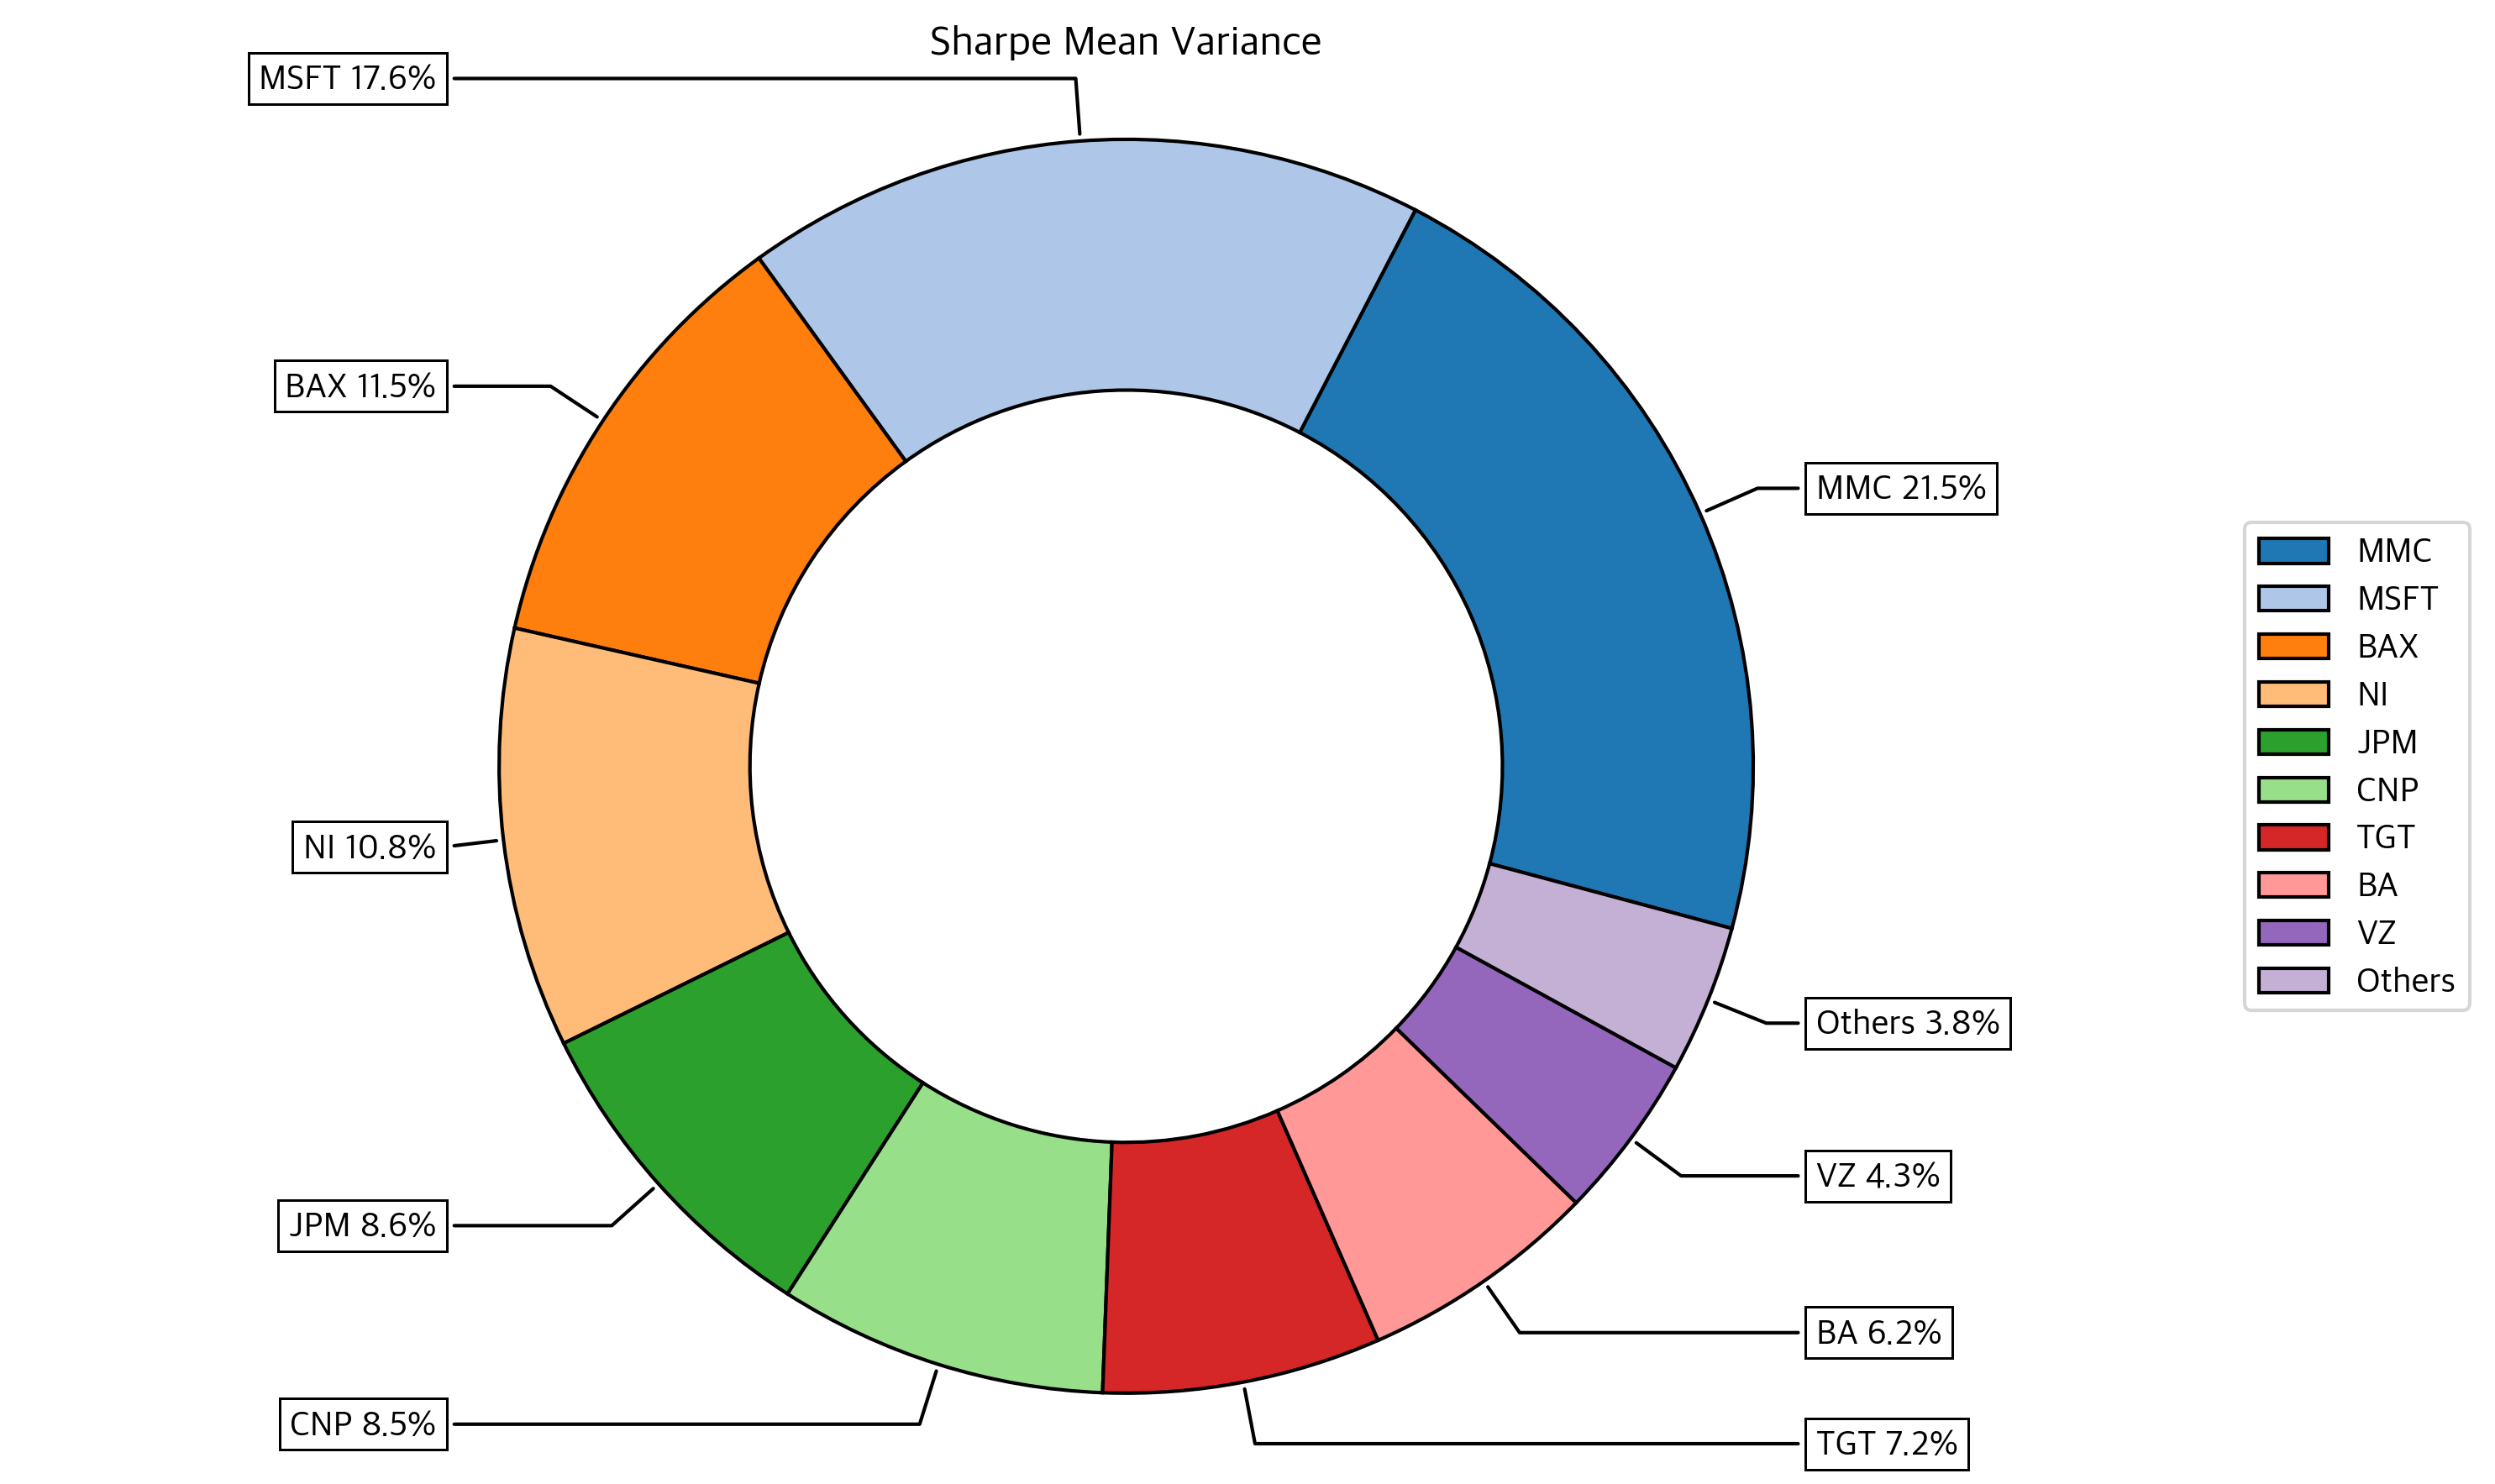

In [20]:
# Plotting the composition of the portfolio

title = 'Sharpe Mean Variance'

ax = rp.plot_pie(w=w, title=title, others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 2.3 Plotting Risk Composition

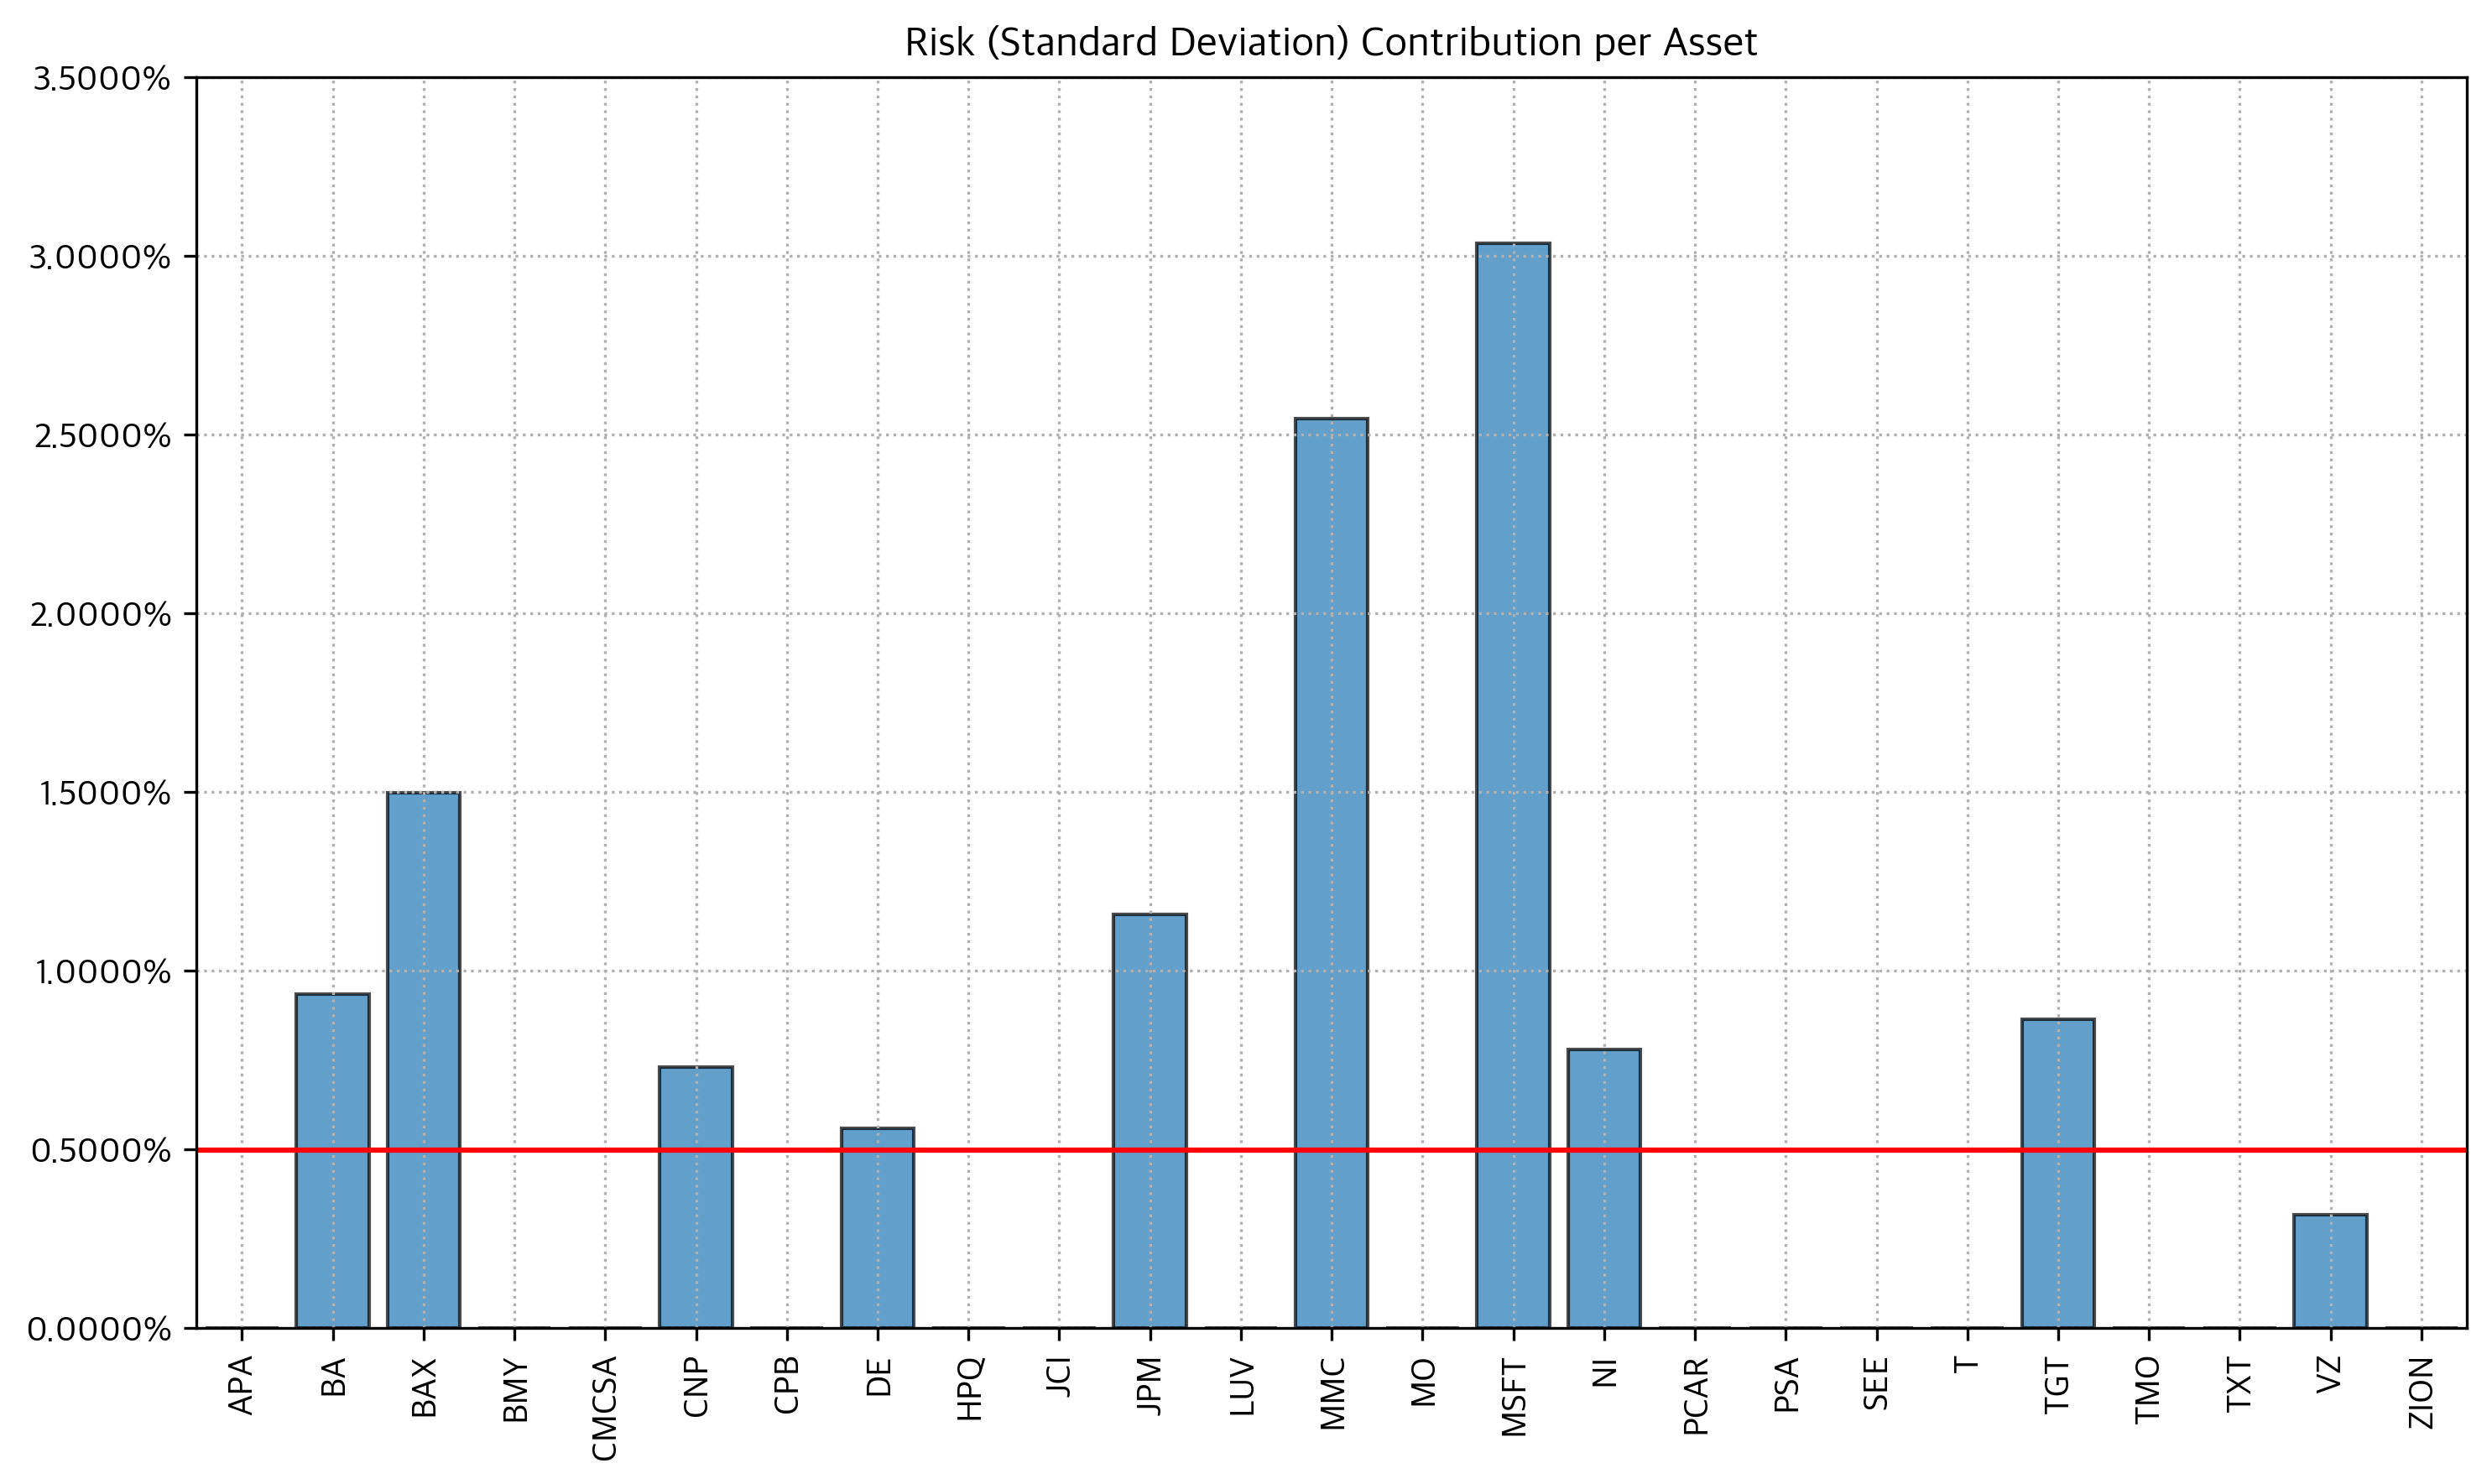

In [21]:
# Plotting the risk composition of the portfolio

ax = rp.plot_risk_con(w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

## 3. Estimating Worst Case Mean Variance Portfolios with Box Uncertainty Sets based on Bootstrapping.

### 3.1 Calculating the worst case mean variance portfolio.

박스 불확실성 집합(Box Uncertainty Sets)을 사용할 것이며, 이 집합의 파라미터는 블록 부트스트래핑(Block Bootstrapping)을 통해 추정될 것입니다. 이는 불확실성 집합의 한계가 백분위수를 기반으로 한다는 것을 의미합니다.

### 박스 불확실성 집합(Box Uncertainty Sets)

박스 불확실성 집합은 각 변수의 값이 특정 범위 내에 있도록 설정한 불확실성 집합입니다. 이는 변수가 고정된 값이 아닌, 일정한 범위 내에서 변동할 수 있음을 나타냅니다. 이 범위는 일반적으로 상한과 하한으로 정의됩니다.

### 블록 부트스트래핑(Block Bootstrapping)

블록 부트스트래핑은 시계열 데이터의 종속성을 유지하면서 부트스트랩 샘플을 생성하는 방법입니다. 이는 원본 데이터에서 일정한 길이의 블록을 무작위로 선택하여 재조합함으로써 새로운 샘플을 생성합니다. 이 방법은 시계열 데이터의 자기상관성을 보존하는 데 유용합니다.

### 불확실성 집합의 한계 설정

불확실성 집합의 한계를 설정하기 위해 백분위수를 사용합니다. 백분위수는 데이터 집합을 100개의 동일한 부분으로 나누는 값으로, 예를 들어, 90번째 백분위수는 데이터의 상위 10%를 초과하는 값입니다. 이를 통해 불확실성 집합의 상한과 하한을 설정할 수 있습니다.

### 전체 과정 설명

1. **박스 불확실성 집합 정의**:
   - 각 변수의 값이 특정 범위(상한과 하한) 내에 있도록 설정합니다.
   - 예를 들어, 자산의 기대 수익률이 5%에서 15% 사이에 있도록 설정할 수 있습니다.

2. **블록 부트스트래핑을 통한 파라미터 추정**:
   - 시계열 데이터를 일정한 길이의 블록으로 나눕니다.
   - 무작위로 블록을 선택하여 새로운 샘플을 생성합니다.
   - 여러 번 반복하여 다양한 샘플을 생성하고, 각 샘플에서 변수의 값을 계산합니다.

3. **백분위수를 기반으로 불확실성 집합의 한계 설정**:
   - 생성된 샘플에서 각 변수의 값에 대한 백분위수를 계산합니다.
   - 예를 들어, 5번째 백분위수와 95번째 백분위수를 사용하여 불확실성 집합의 하한과 상한을 설정할 수 있습니다.
   - 이는 변수의 값이 지정된 백분위수 범위 내에서 변동할 수 있음을 의미합니다.

### 예시

#### 1. 박스 불확실성 집합 정의

```python
# 예시 변수 값
expected_return = 0.10  # 기대 수익률 10%
uncertainty_range = 0.05  # 불확실성 범위 5%

# 불확실성 집합의 상한과 하한
upper_bound = expected_return + uncertainty_range  # 15%
lower_bound = expected_return - uncertainty_range  # 5%
```

#### 2. 블록 부트스트래핑

```python
import numpy as np

# 원본 시계열 데이터
time_series_data = np.random.randn(1000)  # 예시 데이터

# 블록 길이
block_length = 50

# 부트스트랩 샘플 생성
def block_bootstrap(data, block_length, num_samples):
    n = len(data)
    num_blocks = n // block_length
    samples = []

    for _ in range(num_samples):
        sample = []
        for _ in range(num_blocks):
            block_start = np.random.randint(0, n - block_length)
            sample.extend(data[block_start:block_start + block_length])
        samples.append(np.array(sample))
    
    return samples

bootstrap_samples = block_bootstrap(time_series_data, block_length, 1000)
```

#### 3. 백분위수를 기반으로 한계 설정

```python
# 부트스트랩 샘플에서 변수 값 계산 (예: 평균)
bootstrap_means = [np.mean(sample) for sample in bootstrap_samples]

# 백분위수를 사용하여 상한과 하한 설정
lower_percentile = np.percentile(bootstrap_means, 5)
upper_percentile = np.percentile(bootstrap_means, 95)

print(f'불확실성 집합의 하한: {lower_percentile}')
print(f'불확실성 집합의 상한: {upper_percentile}')
```

### 요약

- **박스 불확실성 집합**: 각 변수의 값이 특정 범위 내에 있도록 설정하여 불확실성을 정의합니다.
- **블록 부트스트래핑**: 시계열 데이터의 종속성을 유지하면서 새로운 샘플을 생성하는 방법입니다.
- **백분위수 기반 한계 설정**: 생성된 샘플에서 변수 값의 백분위수를 계산하여 불확실성 집합의 상한과 하한을 설정합니다.

이를 통해 불확실성 집합을 설정하고, 포트폴리오 최적화 문제에서 변수의 값이 지정된 범위 내에서 변동할 수 있도록 할 수 있습니다.

In [22]:
"""
self.cov_l = cov_l
self.cov_u = cov_u
self.cov_mu = cov_mu
self.cov_sigma = cov_sigma
self.d_mu = d_mu
self.k_mu = k_mu
self.k_sigma = k_sigma
"""

print(port.cov_l)

None


In [23]:
# Select method and estimate worst case input parameters:

box = 's' # Method to estimate box uncertainty sets parameters
ellip = 's' # Method to estimate elliptical uncertainty sets parameters
q = 0.05 # Confidence level for bootstrapping and k ellipsoidal uncertainty sets constraints
n_sim = 3000 # Number of scenarios for bootstrapping
window = 3 # Size of each block for block bootstrapping
dmu = 0.1 # delta to increase or decrease the mean vector
dcov = 0.1 # delta to increase or decrease the covariance matrix
seed = 0 

port.wc_stats(box=box, ellip=ellip, q=q, n_sim=n_sim, window=window, dmu=dmu, dcov=dcov, seed=seed)

# Estimate worst case optimal portfolio using selected uncertainty sets:
# port.solvers = ['CLARABEL']

Umu = 'box' # Type of uncertainty set for mean vector
Ucov = 'box' # Type of uncertaity set for covariance matrix

w_wc_1 = port.wc_optimization(obj=obj, rf=rf, l=l, Umu=Umu, Ucov=Ucov)

display(w_wc_1.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,0.0000%,9.7370%,0.0000%,0.0000%,2.8599%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0001%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%


이 코드는 박스(Box)와 타원(Elliptical) 불확실성 집합을 사용하여 최악의 시나리오를 고려한 포트폴리오 최적화를 수행하는 과정입니다. 이 코드는 다양한 불확실성 집합을 기반으로 입력 파라미터를 추정하고, 이를 사용하여 최악의 경우에 최적화된 포트폴리오를 계산합니다. 각 단계별로 코드를 설명하겠습니다.

### 코드 설명

1. **불확실성 집합 파라미터 설정**
   ```python
   box = 's'  # Method to estimate box uncertainty sets parameters
   ellip = 's'  # Method to estimate elliptical uncertainty sets parameters
   q = 0.05  # Confidence level for bootstrapping and k ellipsoidal uncertainty sets constraints
   n_sim = 3000  # Number of scenarios for bootstrapping
   window = 3  # Size of each block for block bootstrapping
   dmu = 0.1  # Delta to increase or decrease the mean vector
   dcov = 0.1  # Delta to increase or decrease the covariance matrix
   seed = 0  # Random seed for reproducibility
   ```

   - `box`: 박스 불확실성 집합의 파라미터 추정 방법.
   - `ellip`: 타원 불확실성 집합의 파라미터 추정 방법.
   - `q`: 부트스트래핑 및 타원 불확실성 집합 제약 조건을 위한 신뢰 수준.
   - `n_sim`: 부트스트래핑을 위한 시나리오 수.
   - `window`: 블록 부트스트래핑을 위한 각 블록의 크기.
   - `dmu`: 평균 벡터를 증가 또는 감소시키는 델타 값.
   - `dcov`: 공분산 행렬을 증가 또는 감소시키는 델타 값.
   - `seed`: 재현성을 위한 랜덤 시드 값.

2. **불확실성 집합 기반 통계량 계산**
   ```python
   port.wc_stats(box=box, ellip=ellip, q=q, n_sim=n_sim, window=window, dmu=dmu, dcov=dcov, seed=seed)
   ```

   - `wc_stats` 함수는 설정된 불확실성 집합 파라미터와 부트스트래핑 방법을 사용하여 최악의 경우에 대한 통계량을 계산합니다.
   - 불확실성 집합의 상한과 하한을 설정하고, 평균 벡터와 공분산 행렬의 변동 범위를 추정합니다.

3. **최악의 경우 최적화 수행**
   ```python
   Umu = 'box'  # Type of uncertainty set for mean vector
   Ucov = 'box'  # Type of uncertainty set for covariance matrix

   w_wc_1 = port.wc_optimization(obj=obj, rf=rf, l=l, Umu=Umu, Ucov=Ucov)
   ```

   - `Umu`: 평균 벡터에 대한 불확실성 집합의 유형을 'box'로 설정합니다.
   - `Ucov`: 공분산 행렬에 대한 불확실성 집합의 유형을 'box'로 설정합니다.
   - `wc_optimization` 함수는 설정된 불확실성 집합을 기반으로 최악의 경우에 대한 최적의 포트폴리오를 계산합니다.
   - `obj`: 최적화 목표 함수 (예: 'Sharpe', 'MinRisk', 'MaxRet', 'Utility' 등).
   - `rf`: 무위험 이자율.
   - `l`: 위험 회피 계수 (obj가 'Utility'일 때만 유용).

4. **최적 포트폴리오 가중치 출력**
   ```python
   display(w_wc_1.T)
   ```

   - `w_wc_1`: 최악의 경우 최적화를 통해 계산된 포트폴리오의 자산 가중치 벡터입니다.
   - `display(w_wc_1.T)`: 계산된 자산 가중치를 출력합니다.

### 요약

- **불확실성 집합 파라미터 설정**: 박스와 타원 불확실성 집합의 파라미터를 설정하고, 부트스트래핑을 위한 파라미터를 정의합니다.
- **불확실성 집합 기반 통계량 계산**: 설정된 파라미터를 사용하여 불확실성 집합의 상한과 하한을 추정하고, 최악의 경우에 대한 통계량을 계산합니다.
- **최악의 경우 최적화 수행**: 추정된 불확실성 집합을 사용하여 최악의 경우에 최적의 포트폴리오를 계산합니다.
- **최적 포트폴리오 가중치 출력**: 계산된 최적의 포트폴리오 가중치를 출력합니다.

이를 통해 불확실성 집합을 고려한 포트폴리오 최적화를 수행하여, 다양한 리스크 시나리오에서 안정적인 포트폴리오를 구성할 수 있습니다.

### 3.2 Plotting portfolio composition

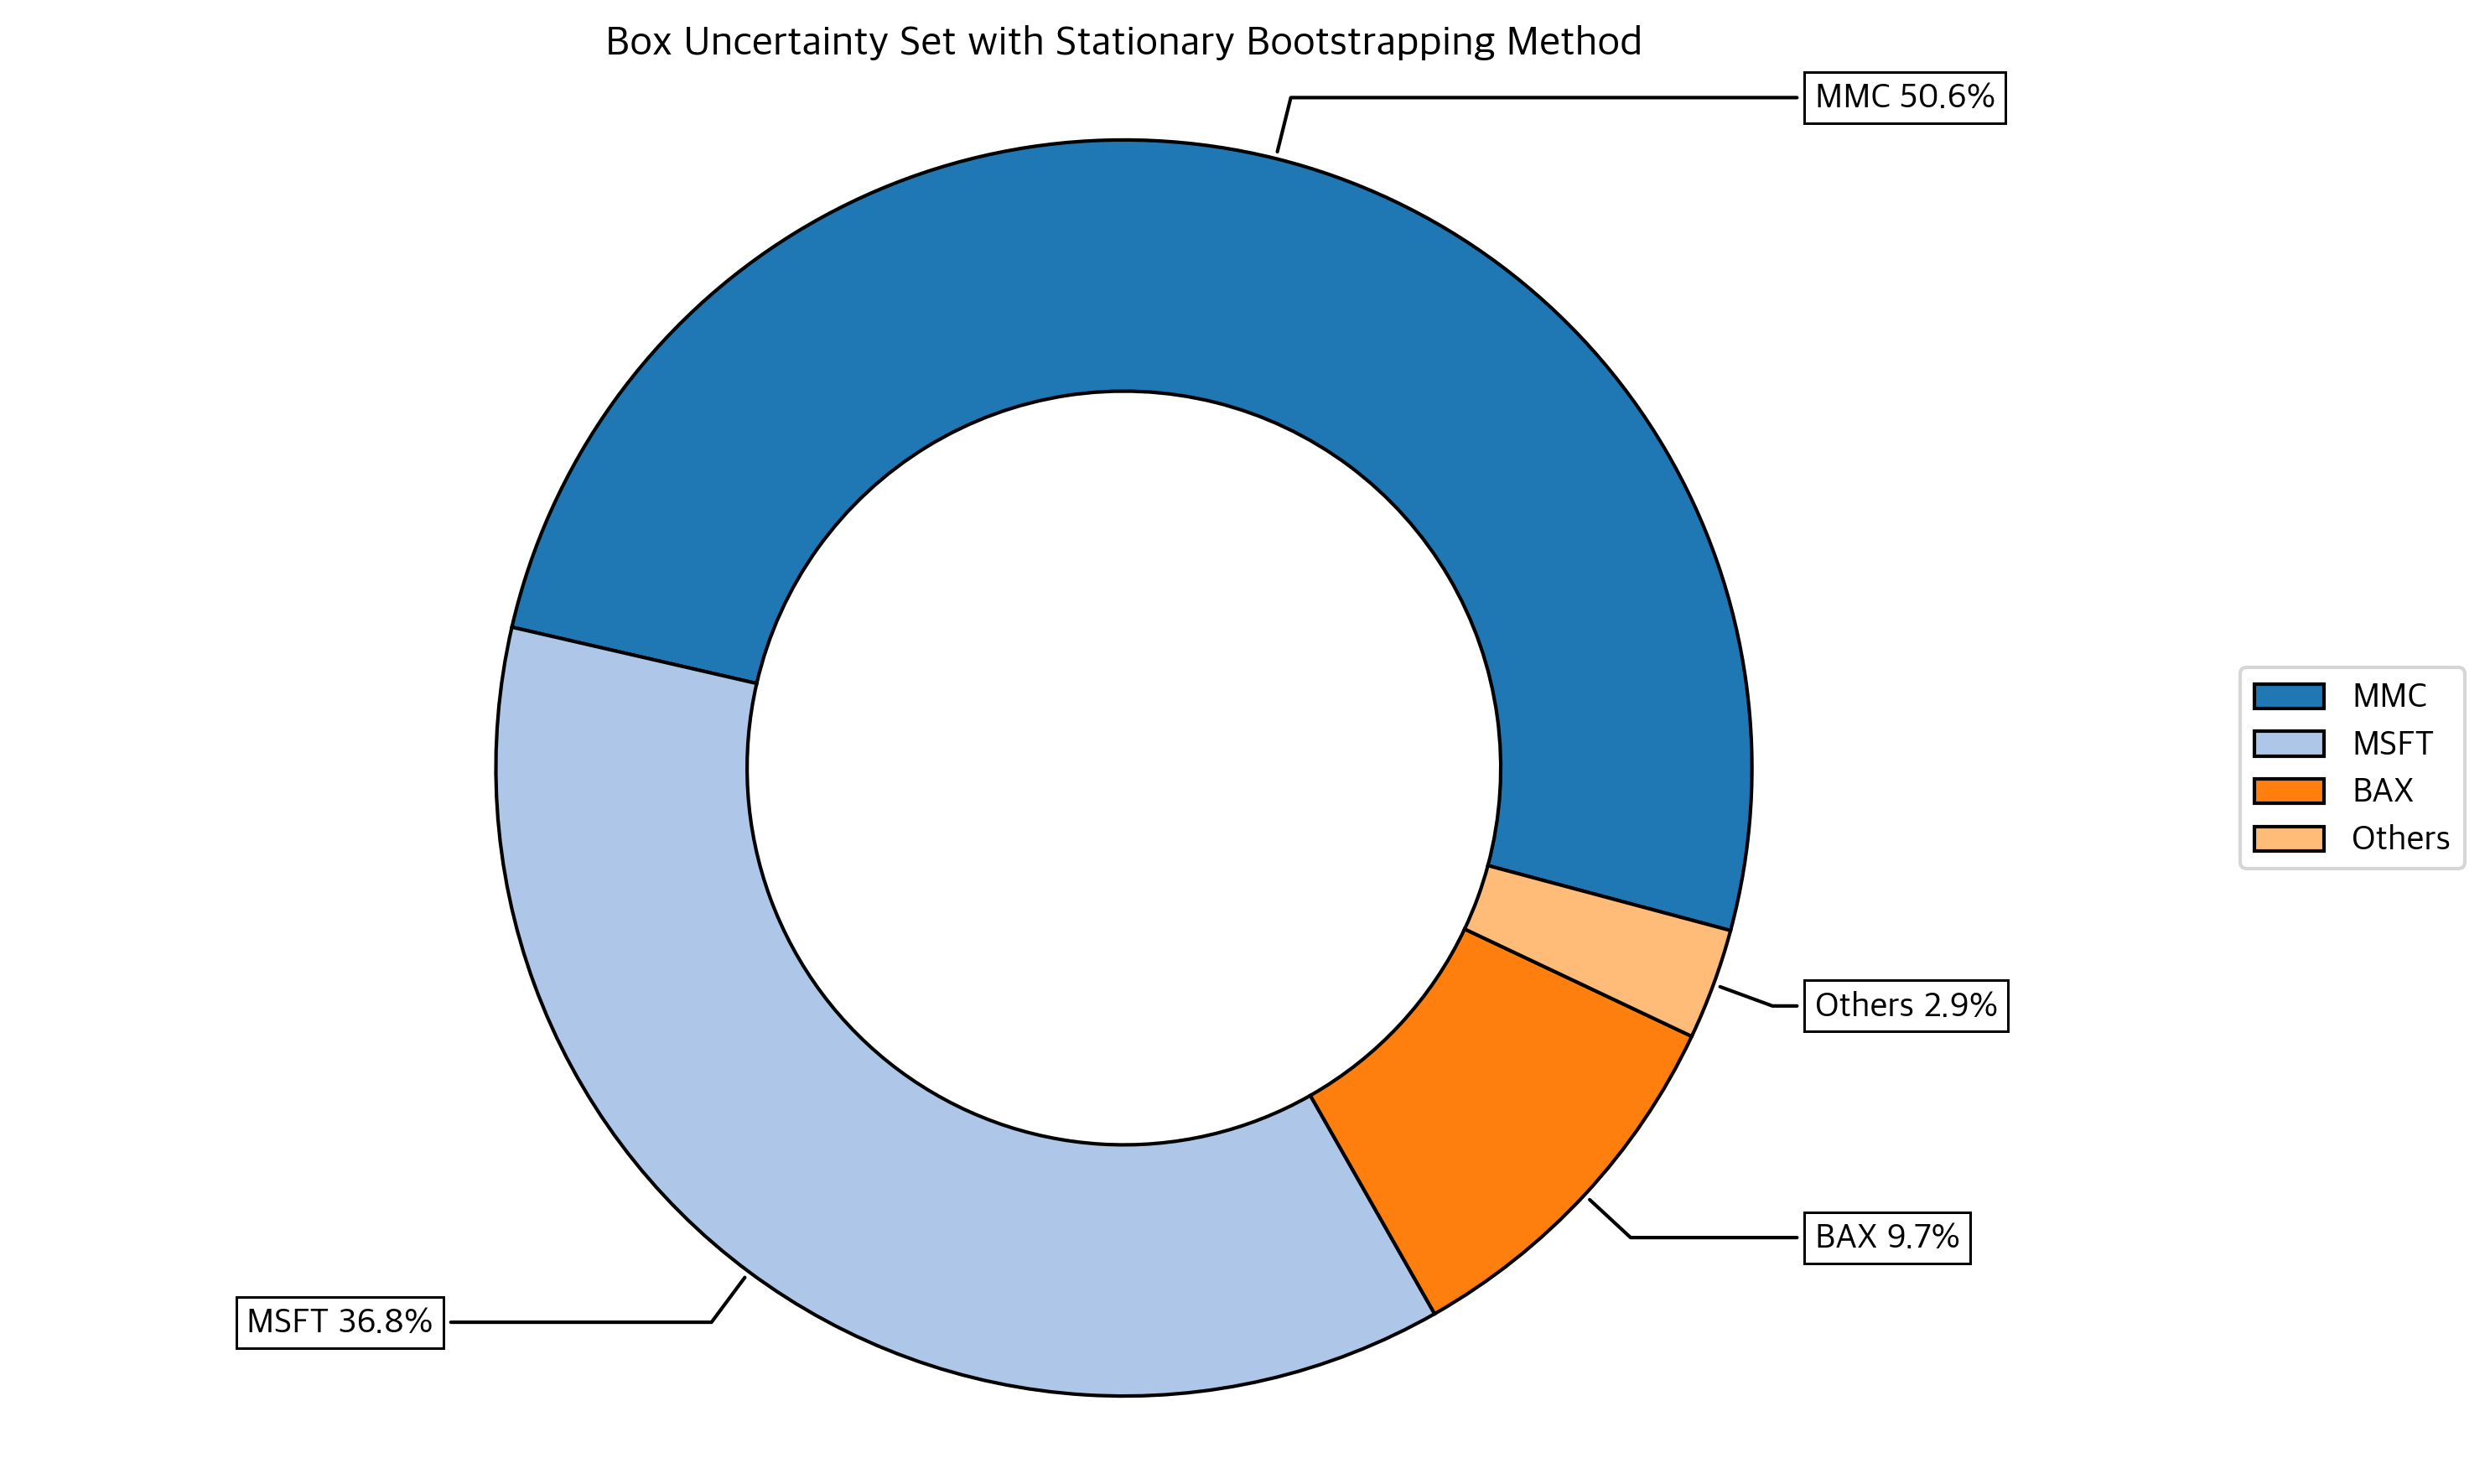

In [24]:
# Plotting the composition of the portfolio

title = 'Box Uncertainty Set with Stationary Bootstrapping Method'

ax = rp.plot_pie(w=w_wc_1, title=title, others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

### 3.3 Plotting Risk Composition

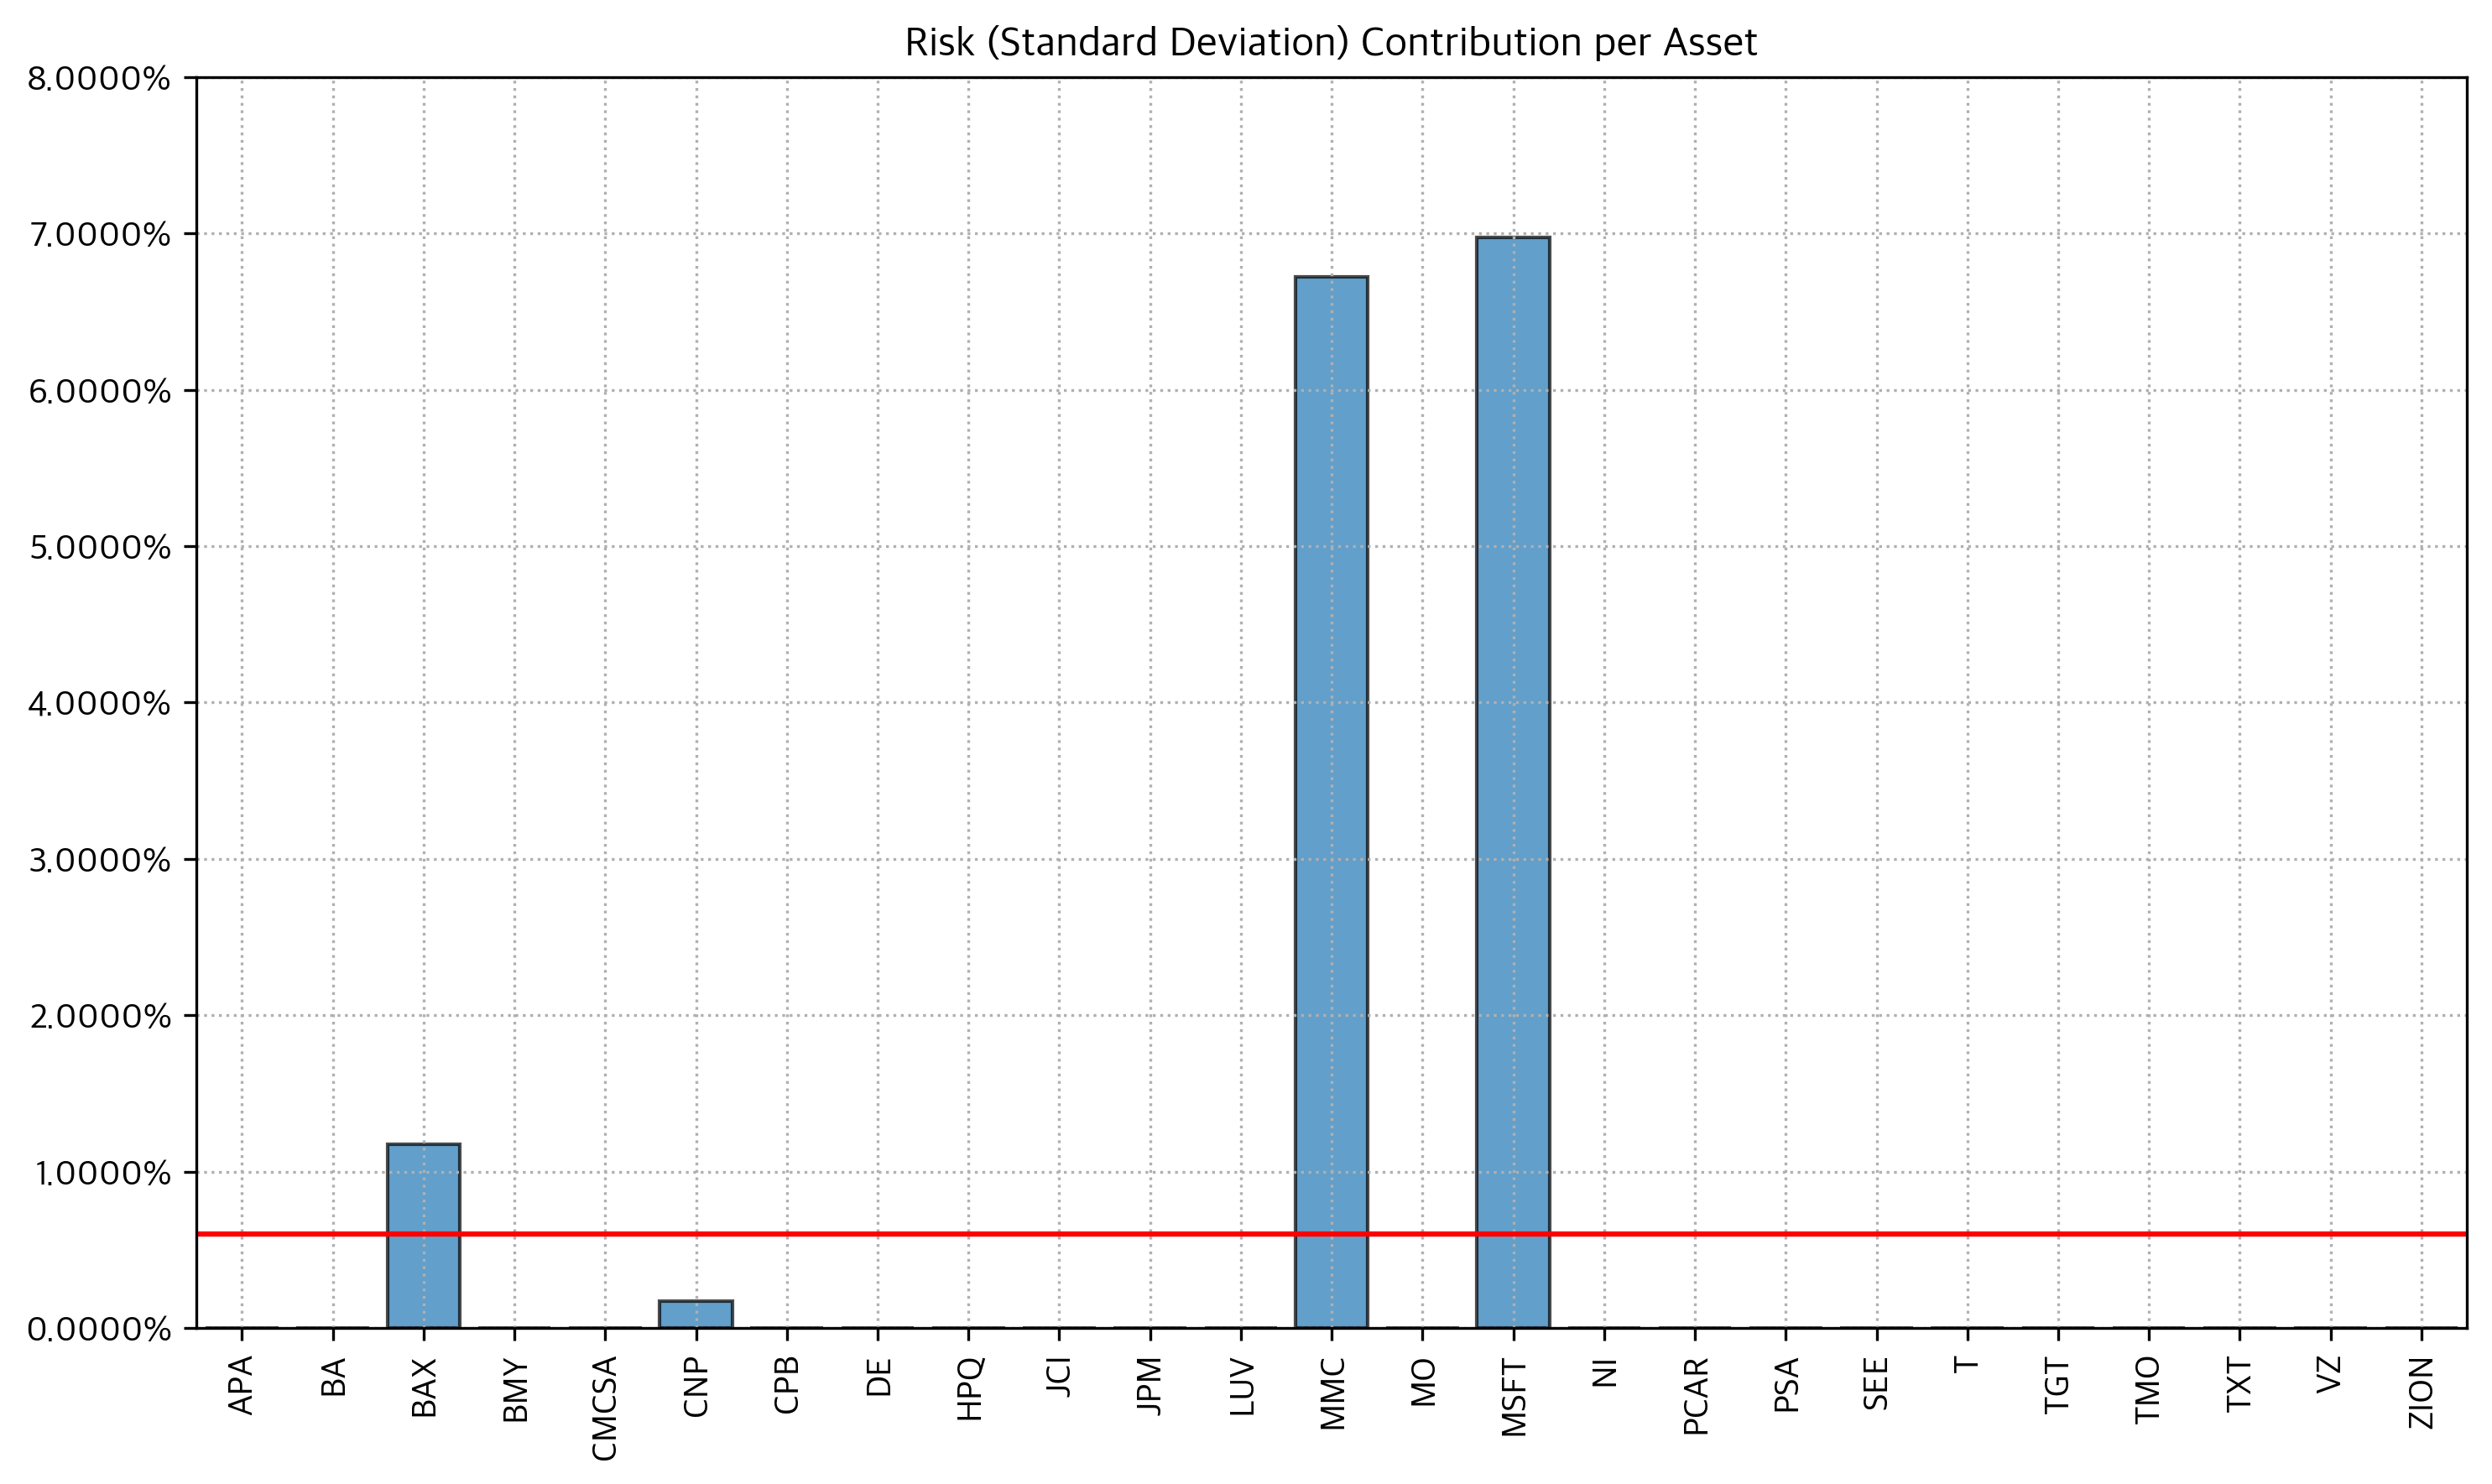

In [25]:
# Plotting the risk composition of the portfolio

ax = rp.plot_risk_con(w_wc_1, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

## 4. Estimating Worst Case Mean Variance Portfolios with Box Uncertainty Sets based on Delta method.

### 4.1 Calculating the worst case mean variance portfolio.

박스 불확실성 집합을 사용할 것이며, 이 집합의 파라미터는 델타 방법을 통해 추정될 것입니다. 이 방법은 평균 벡터와/또는 공분산 행렬을 절대값으로 일정 비율만큼 증가시키거나 감소시키는 것으로 구성됩니다.

In [26]:
# Select method and estimate worst case input parameters:

box = 'd' # Method to estimate box uncertainty sets parameters
ellip = 's' # Method to estimate elliptical uncertainty sets parameters
q = 0.05 # Confidence level for bootstrapping and k ellipsoidal uncertainty sets constraints
n_sim = 3000 # Number of scenarios for bootstrapping
window = 3 # Size of each block for block bootstrapping
dmu = 0.1 # delta to increase or decrease the mean vector
dcov = 0.1 # delta to increase or decrease the covariance matrix
seed = 0

port.wc_stats(box=box, ellip=ellip, q=q, n_sim=n_sim, window=window, dmu=dmu, dcov=dcov, seed=seed)

# Estimate worst case optimal portfolio using selected uncertainty sets:

Umu = 'box' # Type of uncertainty set for mean vector
Ucov = 'box' # Type of uncertainty set for covariance matrix

w_wc_2 = port.wc_optimization(obj=obj, rf=rf, l=l, Umu=Umu, Ucov=Ucov)

display(w_wc_2.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,3.9379%,10.3853%,0.0000%,0.0329%,9.9233%,0.4263%,2.0918%,0.0000%,0.0001%,...,15.0269%,0.0000%,1.1522%,0.0000%,3.3740%,6.7108%,0.0014%,0.0000%,9.2908%,0.0001%


### 델타 방법(Delta Method)

델타 방법(Delta Method)은 주어진 평균 벡터와 공분산 행렬의 불확실성을 고려하여, 이들의 값을 일정 비율만큼 증가시키거나 감소시켜 최악의 경우 시나리오를 생성하는 방법입니다. 이는 특히 금융 및 경제 분야에서 위험을 평가하고 관리하는 데 유용합니다. 이 방법을 사용하면 포트폴리오 최적화 과정에서 더 보수적인 접근을 취할 수 있습니다.

#### 델타 방법의 기본 아이디어

델타 방법은 주어진 평균 벡터와 공분산 행렬에 대해 불확실성 범위를 설정하는 것입니다. 이를 위해 평균 벡터와 공분산 행렬을 각각 일정 비율만큼 증가시키거나 감소시킵니다. 이 비율은 사용자에 의해 설정되며, 보통 델타(Δ)라는 변수로 표현됩니다.

#### 델타 방법의 주요 단계

1. **기본 값 설정**:
   - 주어진 평균 벡터(μ)와 공분산 행렬(Σ)을 기반으로 합니다.

2. **델타 값 적용**:
   - 평균 벡터와 공분산 행렬에 델타 값을 적용하여 상한과 하한을 계산합니다.
   - 평균 벡터의 경우: $\mu_{\text{upper}} = \mu + \Delta$, $\mu_{\text{lower}} = \mu - \Delta$
   - 공분산 행렬의 경우: $\Sigma_{\text{upper}} = \Sigma + \Delta$, $\Sigma_{\text{lower}} = \Sigma - \Delta$

3. **불확실성 집합 생성**:
   - 이러한 상한과 하한을 사용하여 불확실성 집합을 정의합니다. 이 불확실성 집합은 최적화 문제에서 사용됩니다.

#### 예시

1. **기본 값 설정**:

   평균 벡터와 공분산 행렬이 다음과 같다고 가정합니다:
   - $\mu = [0.05, 0.10, 0.15]$
   - $\Sigma = \begin{bmatrix} 0.1 & 0.02 & 0.03 \\ 0.02 & 0.2 & 0.04 \\ 0.03 & 0.04 & 0.3 \end{bmatrix}$

2. **델타 값 적용**:

   델타 값(Δ)을 0.1로 설정합니다:
   - $\Delta = 0.1$

   평균 벡터의 상한과 하한을 계산합니다:
   - $\mu_{\text{upper}} = [0.05 + 0.1, 0.10 + 0.1, 0.15 + 0.1] = [0.15, 0.20, 0.25]$
   - $\mu_{\text{lower}} = [0.05 - 0.1, 0.10 - 0.1, 0.15 - 0.1] = [-0.05, 0.00, 0.05]$

   공분산 행렬의 상한과 하한을 계산합니다:
   - $\Sigma_{\text{upper}} = \begin{bmatrix} 0.1 + 0.1 & 0.02 & 0.03 \\ 0.02 & 0.2 + 0.1 & 0.04 \\ 0.03 & 0.04 & 0.3 + 0.1 \end{bmatrix} = \begin{bmatrix} 0.2 & 0.02 & 0.03 \\ 0.02 & 0.3 & 0.04 \\ 0.03 & 0.04 & 0.4 \end{bmatrix}$
   - $\Sigma_{\text{lower}} = \begin{bmatrix} 0.1 - 0.1 & 0.02 & 0.03 \\ 0.02 & 0.2 - 0.1 & 0.04 \\ 0.03 & 0.04 & 0.3 - 0.1 \end{bmatrix} = \begin{bmatrix} 0.0 & 0.02 & 0.03 \\ 0.02 & 0.1 & 0.04 \\ 0.03 & 0.04 & 0.2 \end{bmatrix}$

3. **불확실성 집합 생성**:

   이러한 상한과 하한을 사용하여 불확실성 집합을 정의하고, 최적화 문제에서 사용합니다.

### 실제 코드 예제

다음은 위의 단계를 실제 코드로 구현한 예제입니다:

```python
import numpy as np
import riskfolio as rp

# 평균 벡터와 공분산 행렬 설정
mu = np.array([0.05, 0.10, 0.15])
cov = np.array([[0.1, 0.02, 0.03],
                [0.02, 0.2, 0.04],
                [0.03, 0.04, 0.3]])

# 델타 값 설정
dmu = 0.1
dcov = 0.1

# 상한과 하한 계산
mu_upper = mu + dmu
mu_lower = mu - dmu
cov_upper = cov + dcov
cov_lower = cov - dcov

print("평균 벡터의 상한:", mu_upper)
print("평균 벡터의 하한:", mu_lower)
print("공분산 행렬의 상한:\n", cov_upper)
print("공분산 행렬의 하한:\n", cov_lower)

# 포트폴리오 객체 생성
port = rp.Portfolio(returns=Y)  # Y는 수익률 데이터프레임

# wc_stats 함수를 사용하여 불확실성 집합 파라미터 추정
port.wc_stats(box='d', ellip='s', q=0.05, n_sim=3000, window=3, dmu=dmu, dcov=dcov, seed=0)

# 최악의 경우 최적화 수행
w_wc_2 = port.wc_optimization(obj=obj, rf=rf, l=l, Umu='box', Ucov='box')

# 최적 포트폴리오 가중치 출력
display(w_wc_2.T)
```

### 요약

- **델타 방법**: 주어진 평균 벡터와 공분산 행렬을 일정 비율만큼 증가 또는 감소시켜 불확실성 집합을 생성합니다.
- **불확실성 집합**: 이러한 변동 범위를 사용하여 최적화 문제에서 고려할 상한과 하한을 설정합니다.
- **포트폴리오 최적화**: 최악의 경우를 고려한 보수적인 포트폴리오를 구성하여 다양한 리스크 시나리오에 대비합니다.

델타 방법은 불확실성을 고려한 포트폴리오 최적화에 유용한 도구이며, 특히 변동성이 큰 시장 환경에서 안정적인 포트폴리오를 구성하는 데 도움이 됩니다.

### 4.2 Plotting portfolio composition

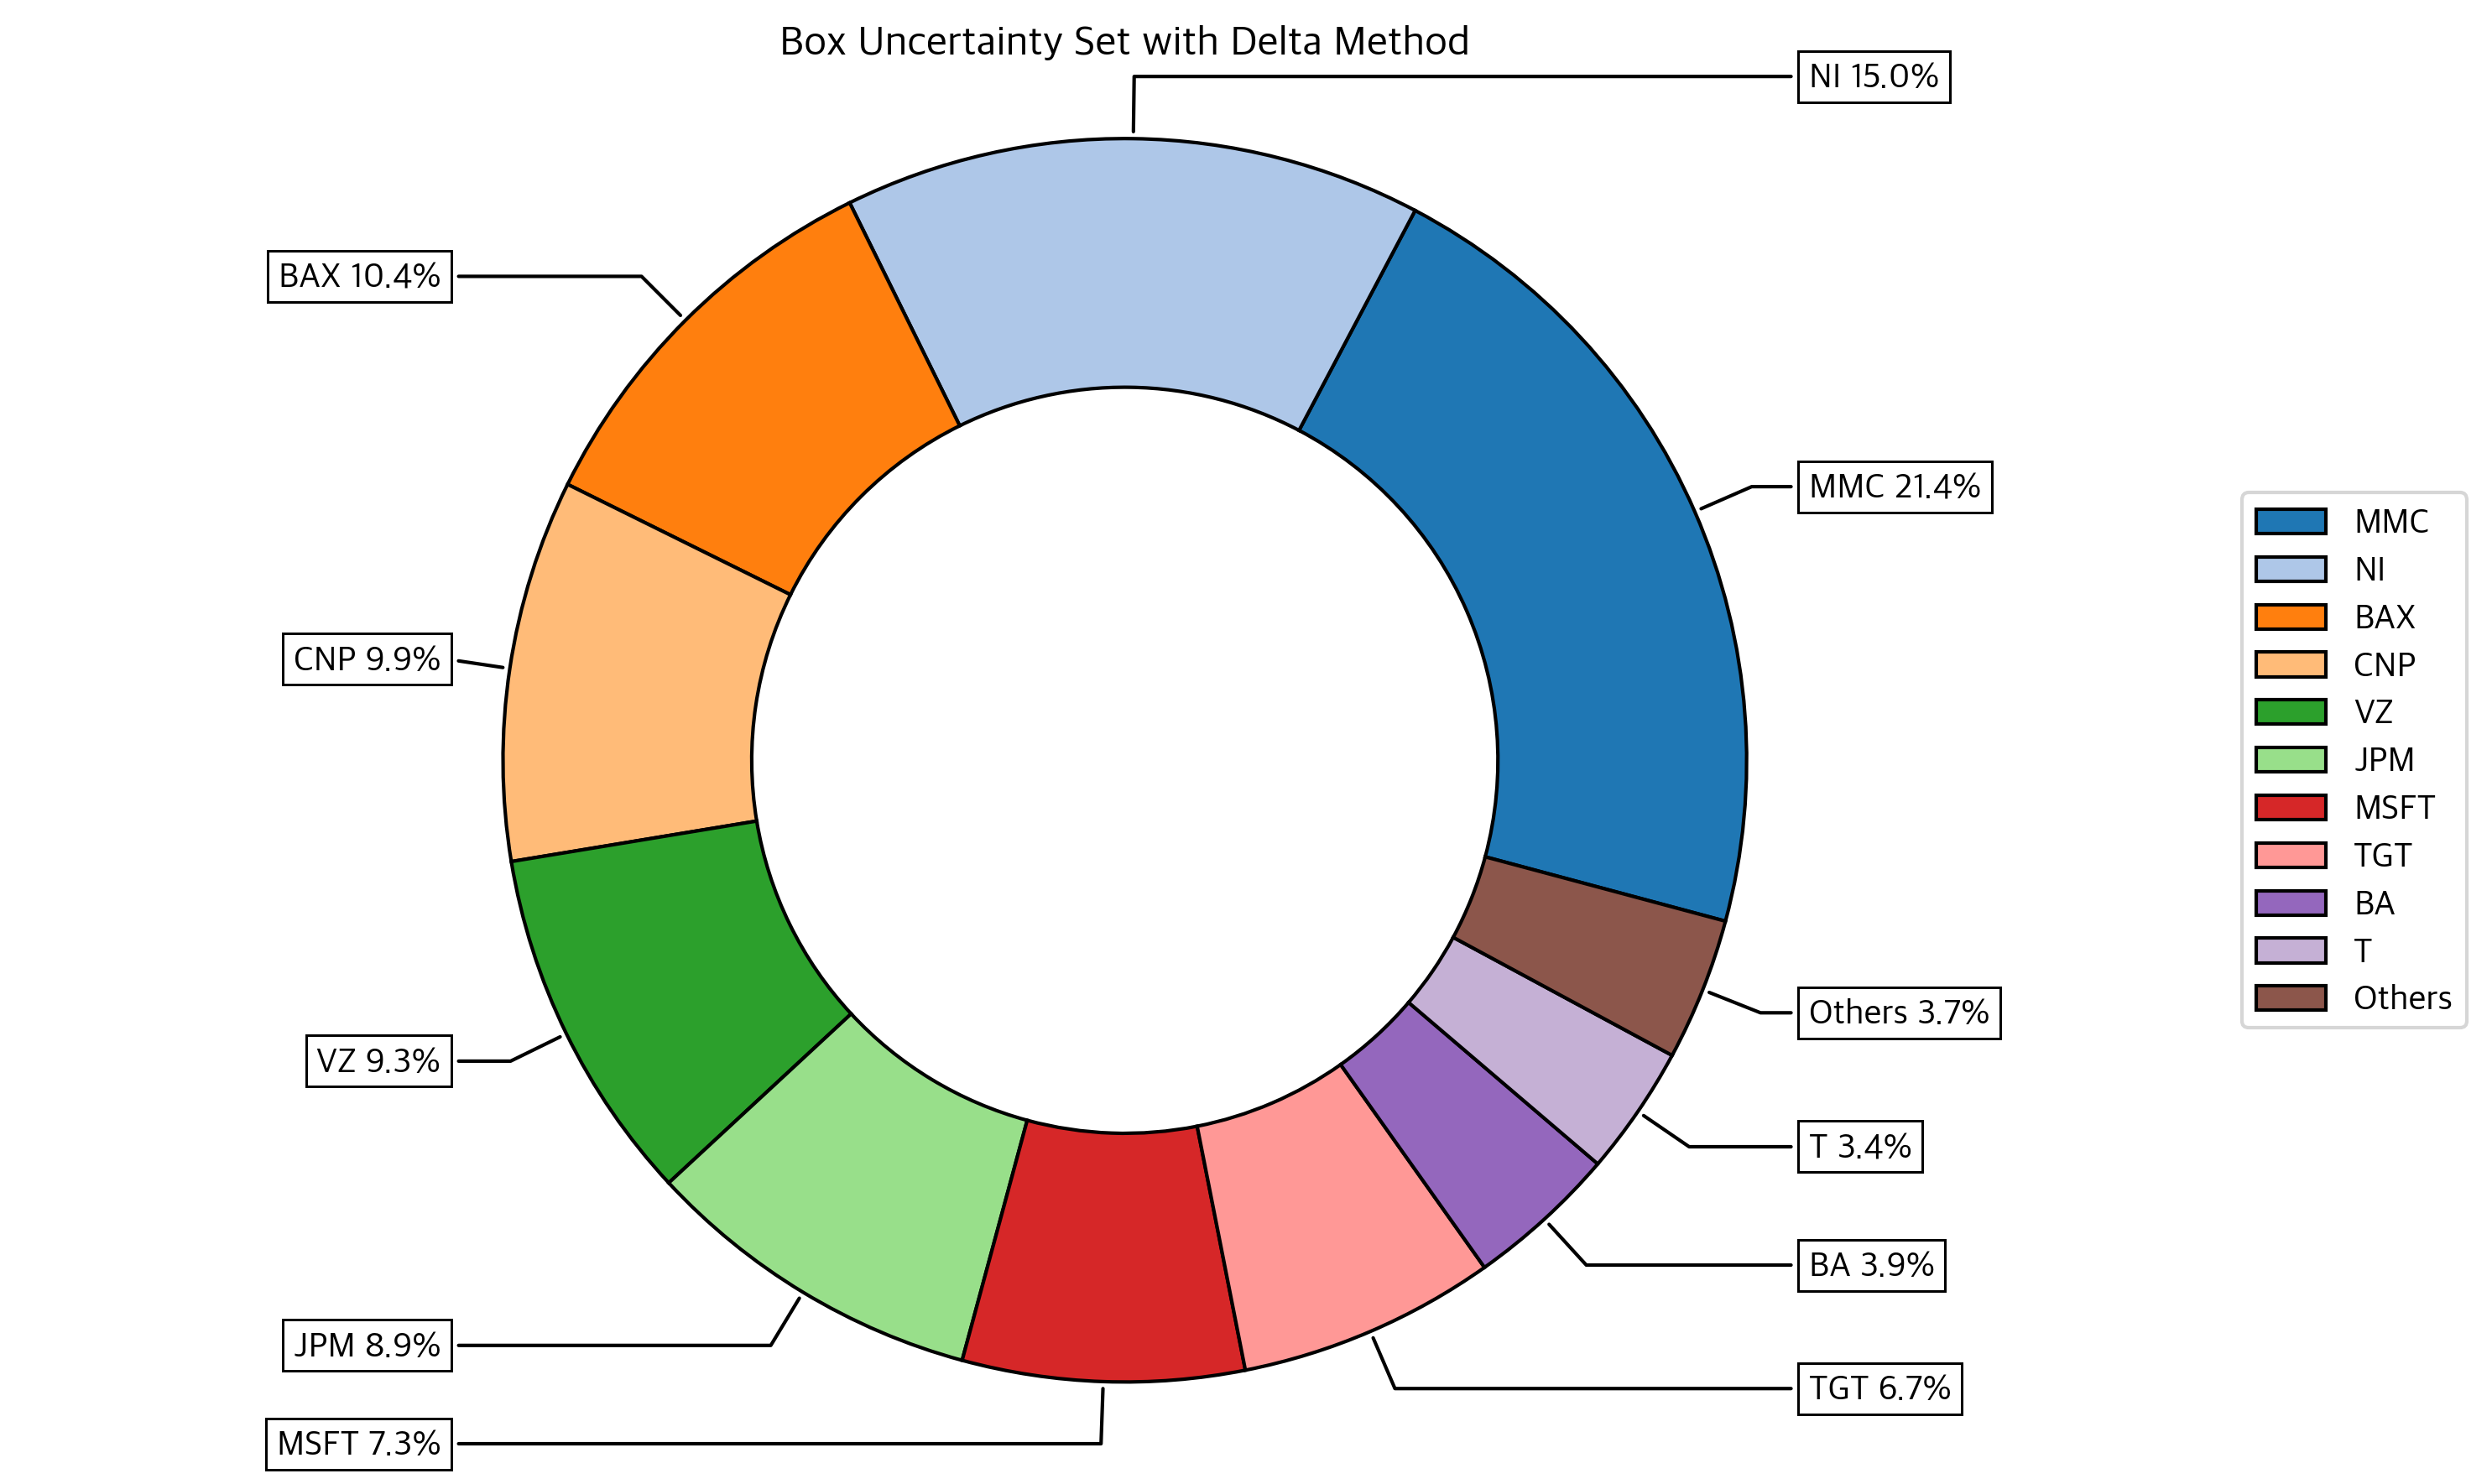

In [27]:
# Plotting the composition of the portfolio

title = 'Box Uncertainty Set with Delta Method'

ax = rp.plot_pie(w=w_wc_2, title=title, others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 4.3 Plotting risk composition

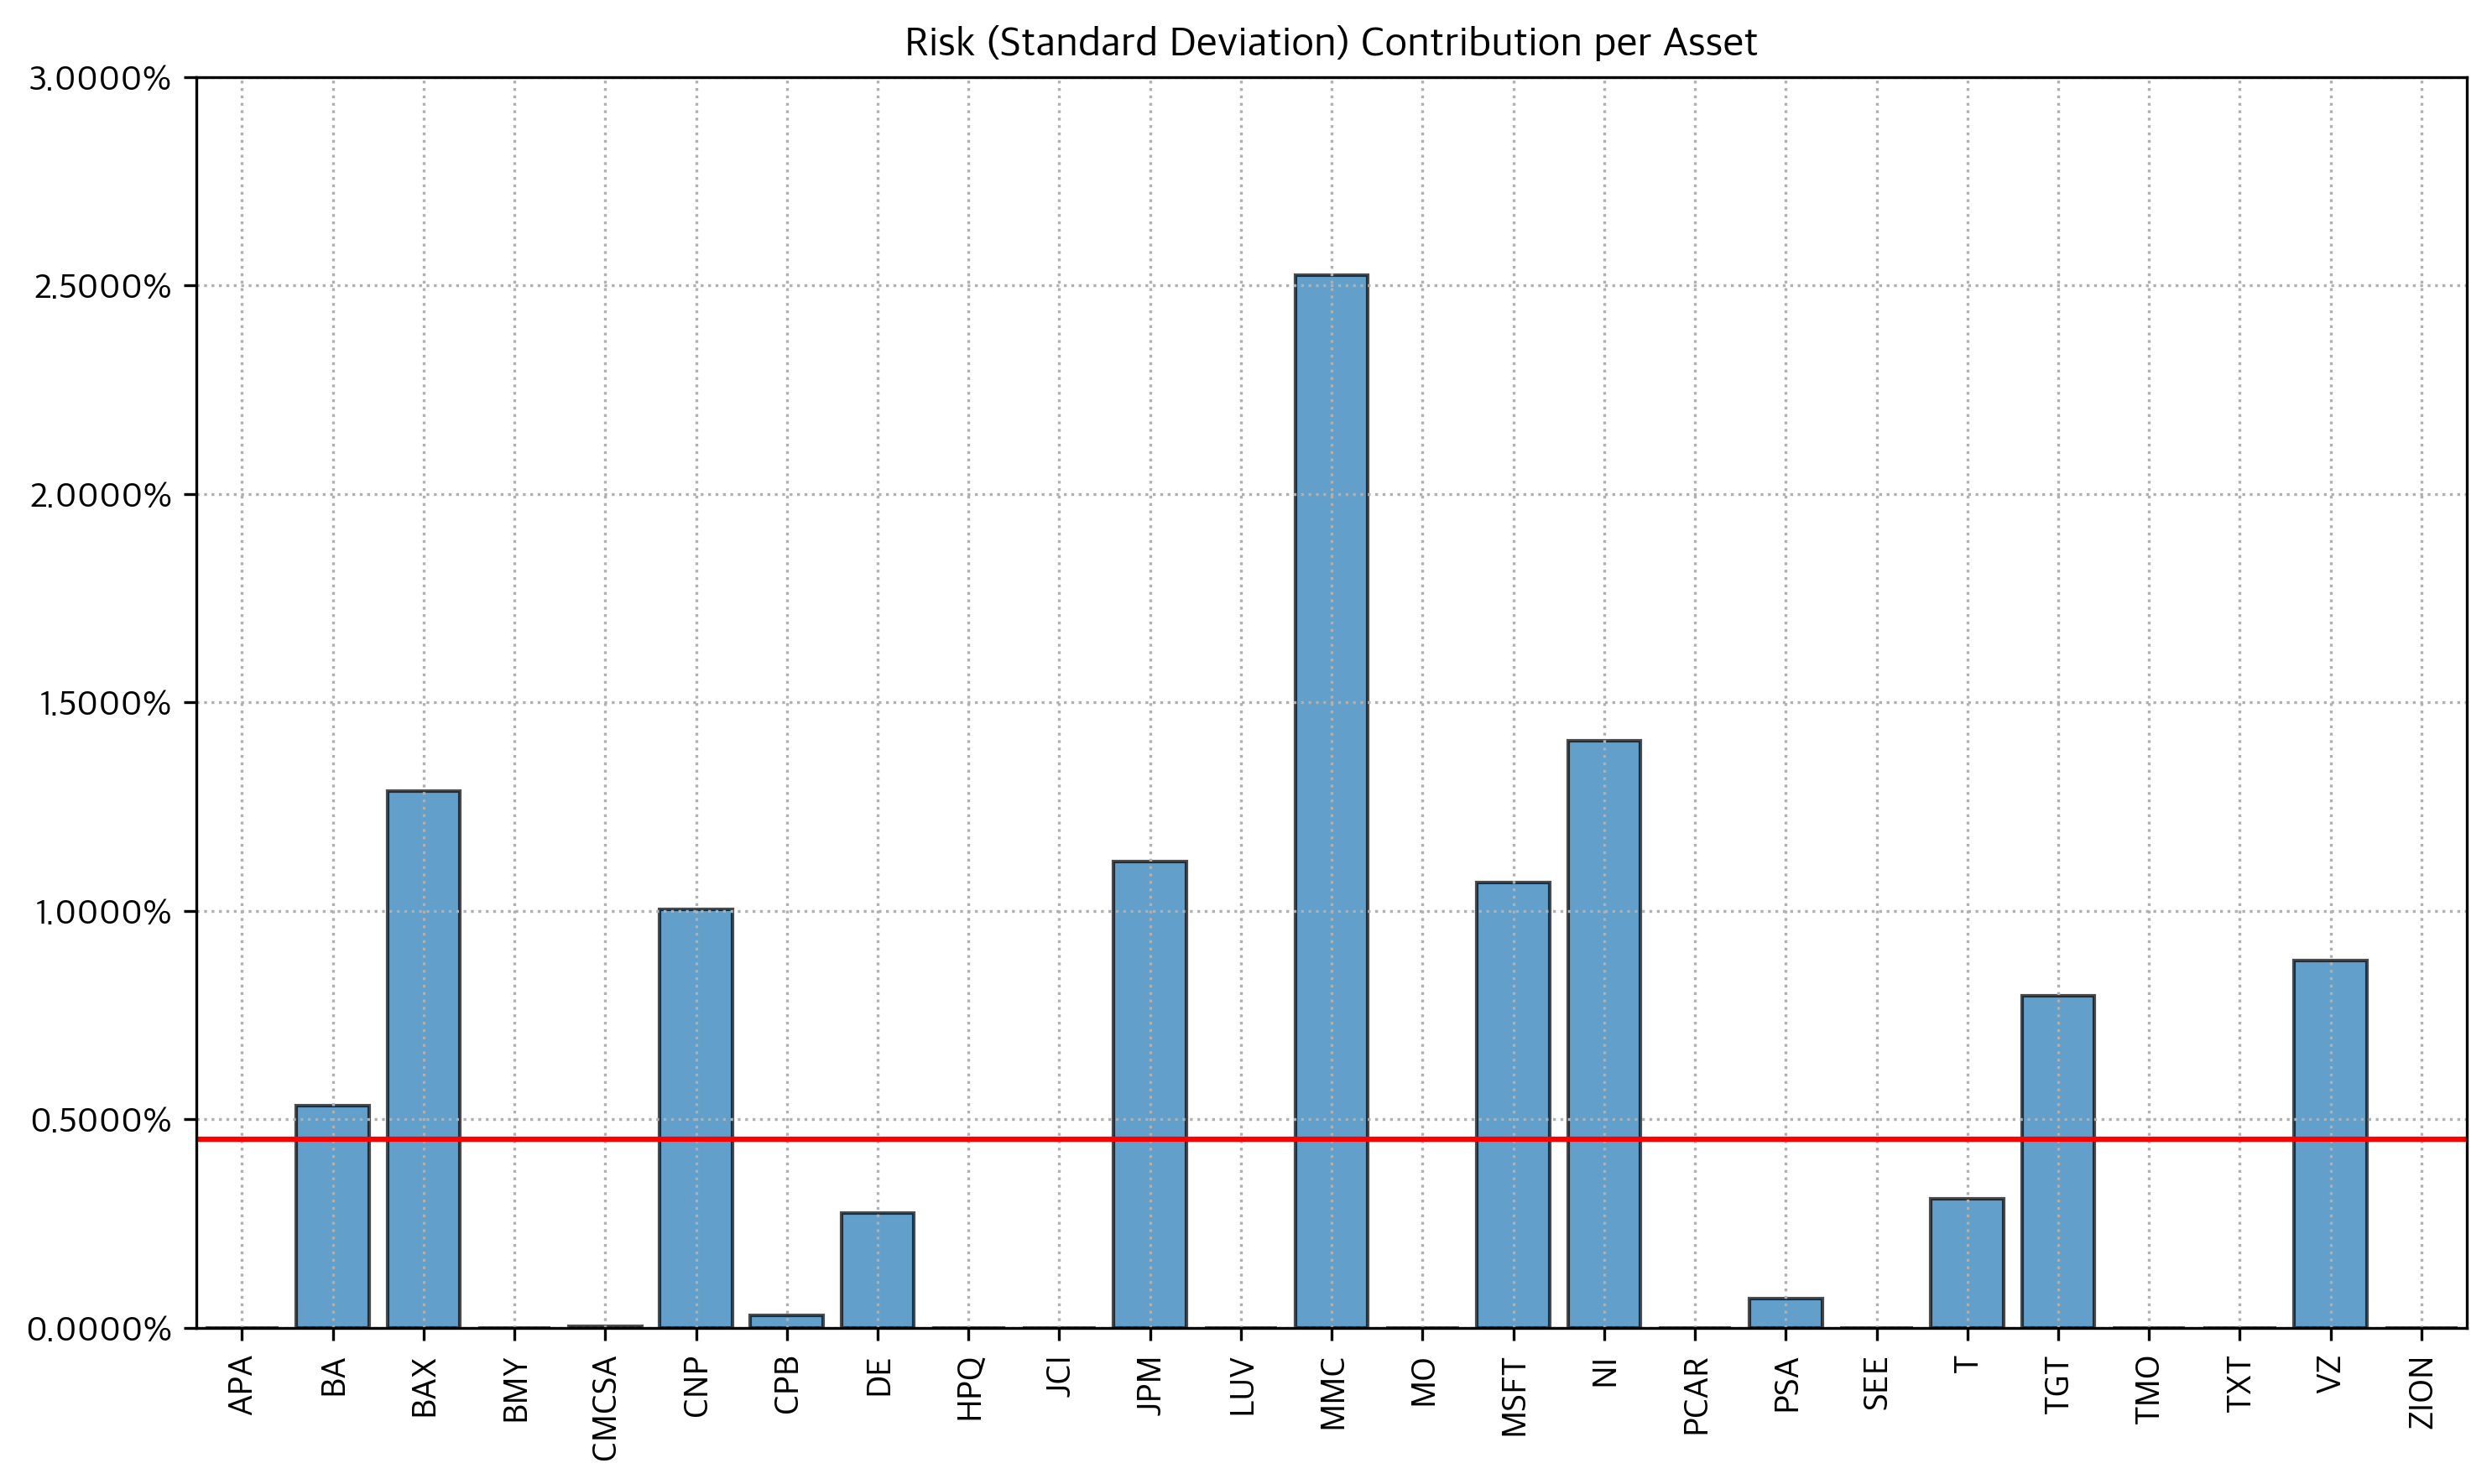

In [28]:
# Plotting the risk composition of the portfolio

ax = rp.plot_risk_con(w_wc_2, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

## 5. Estimating Worst Case Mean Variance Portfolios with Elliptical Uncertainty Sets based on Bootstrapping.

### 5.1 Calculating the worst case mean variance portfolio.

평균 벡터와 공분산 행렬에 대해 타원형 불확실성 집합을 사용할 것입니다. 이 집합의 파라미터는 정적 블록 부트스트래핑(stationary block bootstrapping)을 통해 추정될 것입니다.

In [29]:
# Select method and estimate worst case input parameters:

box = 's' # Method to estimate box uncertainty sets parameters
ellip = 's' # Method to estimate elliptical uncertainty sets parameters
q = 0.05 # Confidence level for bootstrapping and k ellipsoidal uncertainty sets constraints
n_sim = 6000 # Number of scenarios for bootstrapping
window = 3 # Size of each block for block bootstrapping
dmu = 0.1 # delta to increase or decrease the mean vector
dcov = 0.1 # delta to increase or decrease the covariance matrix
seed = 0

port.wc_stats(box=box, ellip=ellip, q=q, n_sim=n_sim, window=window, diag=False, dmu=dmu, dcov=dcov, seed=seed)

print(port.k_mu)
print(port.k_sigma)
port.solvers = ['SCS']

# Estimate worst case optimal portfolio using selected uncertainty sets:

Umu = 'ellip' # Type of uncertainty set for mean vector
Ucov = 'ellip' # Type of uncertainty set for covariance matrix

w_wc_3 = port.wc_optimization(obj=obj, rf=rf, l=l, Umu=Umu, Ucov=Ucov)

display(w_wc_3.T)

6.133628222300289
35.63530634542045


,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,4.9403%,0.0000%,0.0000%,0.0000%,0.0843%,0.0097%,0.0197%,0.0000%,0.0000%,...,0.0869%,0.0000%,0.0000%,0.0000%,0.0244%,0.0146%,0.0000%,0.0000%,0.0846%,0.0000%


### 타원 불확실성 집합(Elliptical Uncertainty Sets)

타원 불확실성 집합은 주어진 평균 벡터와 공분산 행렬을 중심으로 하는 타원 형태의 불확실성 영역을 정의합니다. 이는 금융 및 경제 분야에서 포트폴리오 최적화 문제를 해결할 때 널리 사용됩니다. 타원 불확실성 집합은 변수들이 상관관계를 가지면서도 일정한 범위 내에서 변동할 수 있음을 나타냅니다.

### 타원 불확실성 집합의 정의

타원 불확실성 집합은 다음과 같은 형태로 정의됩니다:

$$ \mathcal{U} = \{ \mu : (\mu - \hat{\mu})^T \Sigma^{-1} (\mu - \hat{\mu}) \leq k_\mu \} $$

여기서:
- $\mathcal{U}$는 불확실성 집합을 의미합니다.
- $\mu$는 실제 평균 벡터입니다.
- $\hat{\mu}$는 추정된 평균 벡터입니다.
- $\Sigma$는 공분산 행렬입니다.
- $k_\mu$는 신뢰 수준에 해당하는 스케일링 팩터입니다.

위의 정의에서 타원 불확실성 집합은 중심이 $\hat{\mu}$이고, 공분산 구조가 $\Sigma$인 타원체로 표현됩니다. $k_\mu$는 타원의 크기를 조절하며, 이는 신뢰 수준과 관련이 있습니다.

### 타원 불확실성 집합의 특징

1. **상관관계 반영**: 타원 불확실성 집합은 공분산 행렬 $\Sigma$를 통해 변수들 간의 상관관계를 반영합니다.
2. **가변적인 범위**: 신뢰 수준에 따라 타원의 크기를 조절할 수 있습니다. 높은 신뢰 수준은 더 큰 타원을 의미하며, 이는 더 많은 불확실성을 허용합니다.
3. **보수적인 접근**: 타원 불확실성 집합은 평균 벡터와 공분산 행렬의 변동성을 동시에 고려하여 보수적인 포트폴리오 최적화를 가능하게 합니다.

### 타원 불확실성 집합의 사용 예

1. **평균 벡터의 타원 불확실성 집합**:
   - 주어진 평균 벡터 $\hat{\mu}$와 공분산 행렬 $\Sigma$를 중심으로 타원을 생성합니다.
   - 신뢰 수준 $q$에 따라 스케일링 팩터 $k_\mu$를 설정합니다.

2. **공분산 행렬의 타원 불확실성 집합**:
   - 주어진 공분산 행렬 $\hat{\Sigma}$을 중심으로 타원을 생성합니다.
   - 신뢰 수준 $q$에 따라 스케일링 팩터 $k_\Sigma$를 설정합니다.

### 코드 예시

다음은 타원 불확실성 집합을 사용하여 포트폴리오 최적화를 수행하는 예시입니다:

```python
import riskfolio as rp
import numpy as np

# 데이터 준비
np.random.seed(0)
Y = np.random.randn(100, 5)  # 예제 데이터 (100개의 샘플, 5개의 자산)

# 포트폴리오 객체 생성
port = rp.Portfolio(returns=Y)

# 불확실성 집합 파라미터 설정
box = 's'
ellip = 's'
q = 0.05
n_sim = 6000
window = 3
dmu = 0.1
dcov = 0.1
seed = 0

# 불확실성 집합 기반 통계량 계산
port.wc_stats(box=box, ellip=ellip, q=q, n_sim=n_sim, window=window, diag=False, dmu=dmu, dcov=dcov, seed=seed)

print("k_mu:", port.k_mu)
print("k_sigma:", port.k_sigma)

# 최적화 솔버 설정
port.solvers = ['MOSEK']

# 최악의 경우 최적화 수행
Umu = 'ellip'
Ucov = 'ellip'

# 최적화 목표 설정
obj = 'Sharpe'  # 예시로 샤프 비율을 최대화하는 목표
rf = 0  # 무위험 이자율
l = 0  # 위험 회피 계수 (obj가 'Utility'일 때 사용)

w_wc_3 = port.wc_optimization(obj=obj, rf=rf, l=l, Umu=Umu, Ucov=Ucov)

# 최적 포트폴리오 가중치 출력
print(w_wc_3.T)
```

### 요약

- **타원 불확실성 집합(Elliptical Uncertainty Sets)**: 평균 벡터와 공분산 행렬을 중심으로 타원 형태의 불확실성 영역을 정의합니다.
- **특징**:
  - 상관관계를 반영하여 변수들 간의 상호작용을 고려합니다.
  - 신뢰 수준에 따라 타원의 크기를 조절할 수 있습니다.
  - 보수적인 포트폴리오 최적화를 가능하게 합니다.
- **포트폴리오 최적화**:
  - 타원 불확실성 집합을 사용하여 최악의 경우 시나리오를 고려한 포트폴리오를 최적화합니다.
  - 이는 다양한 리스크 시나리오에서 안정적인 포트폴리오를 구성하는 데 도움이 됩니다.

이 방법을 통해 불확실성 집합을 고려한 포트폴리오 최적화를 수행하여, 다양한 리스크 시나리오에 대비할 수 있습니다.

### 5.2 Plotting portfolio composition

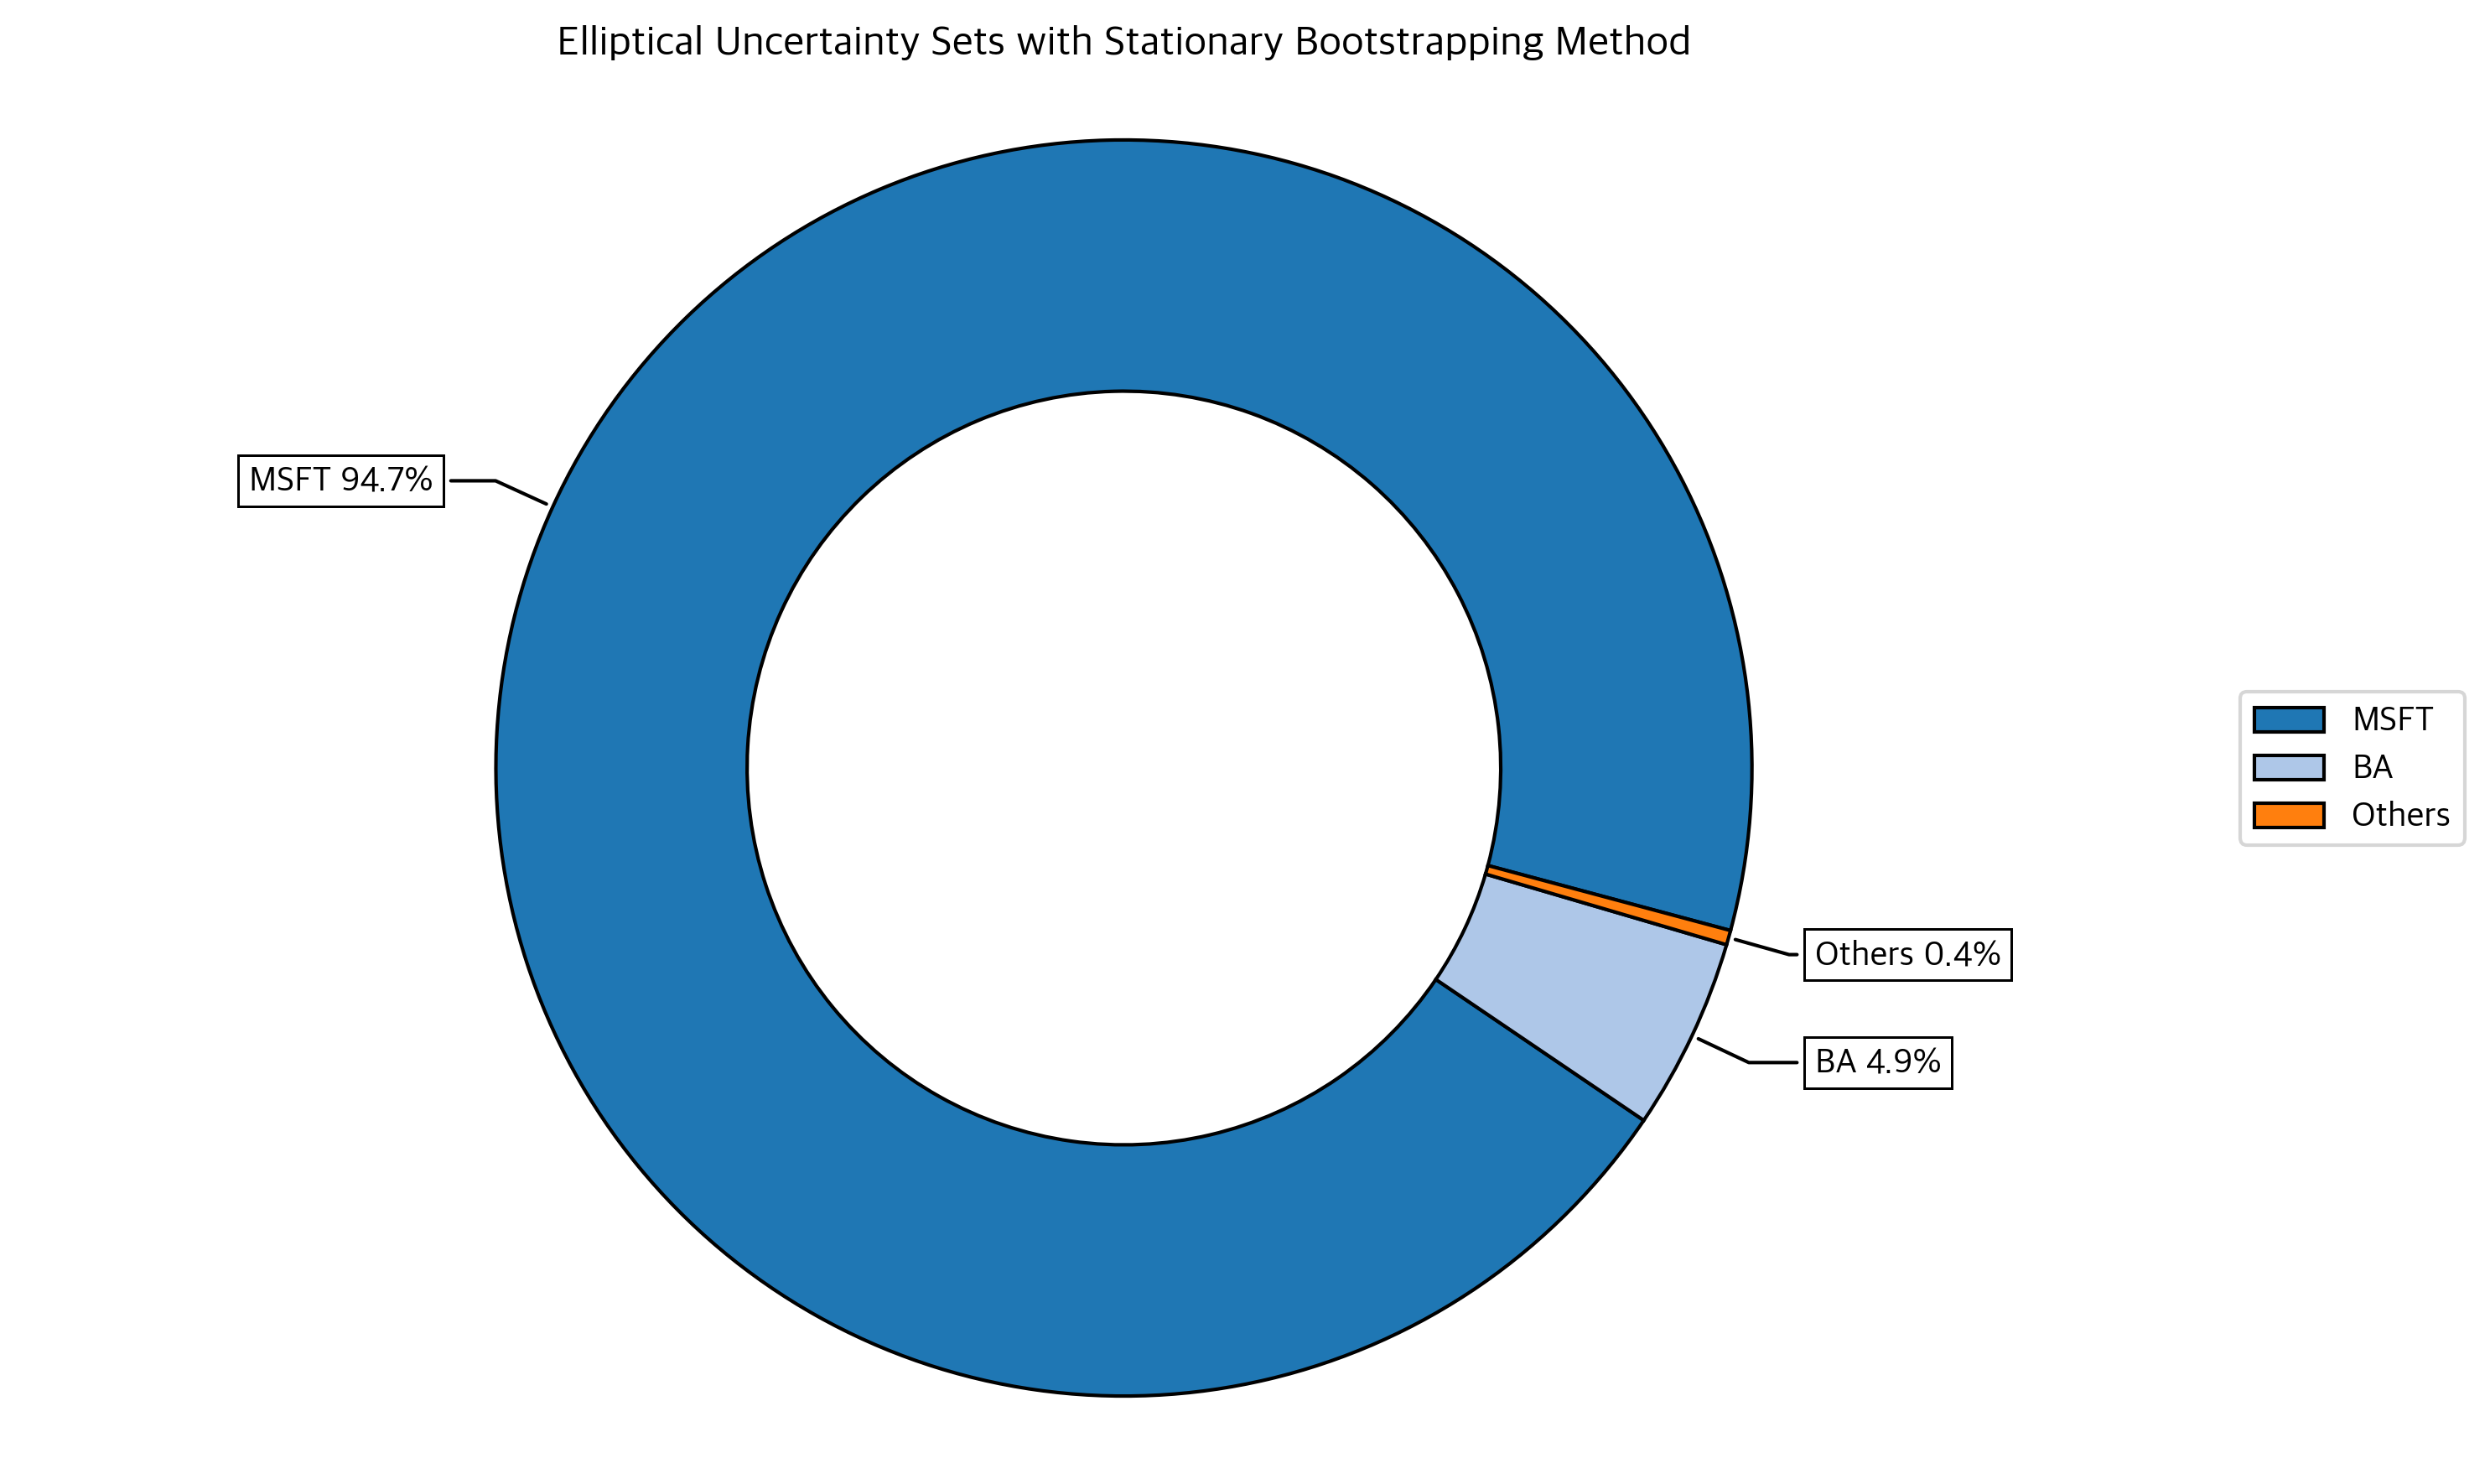

In [30]:
# Plotting the composition of the portfolio

title = 'Elliptical Uncertainty Sets with Stationary Bootstrapping Method'

ax = rp.plot_pie(w=w_wc_3, title=title, others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

### 5.3 Plotting risk composition

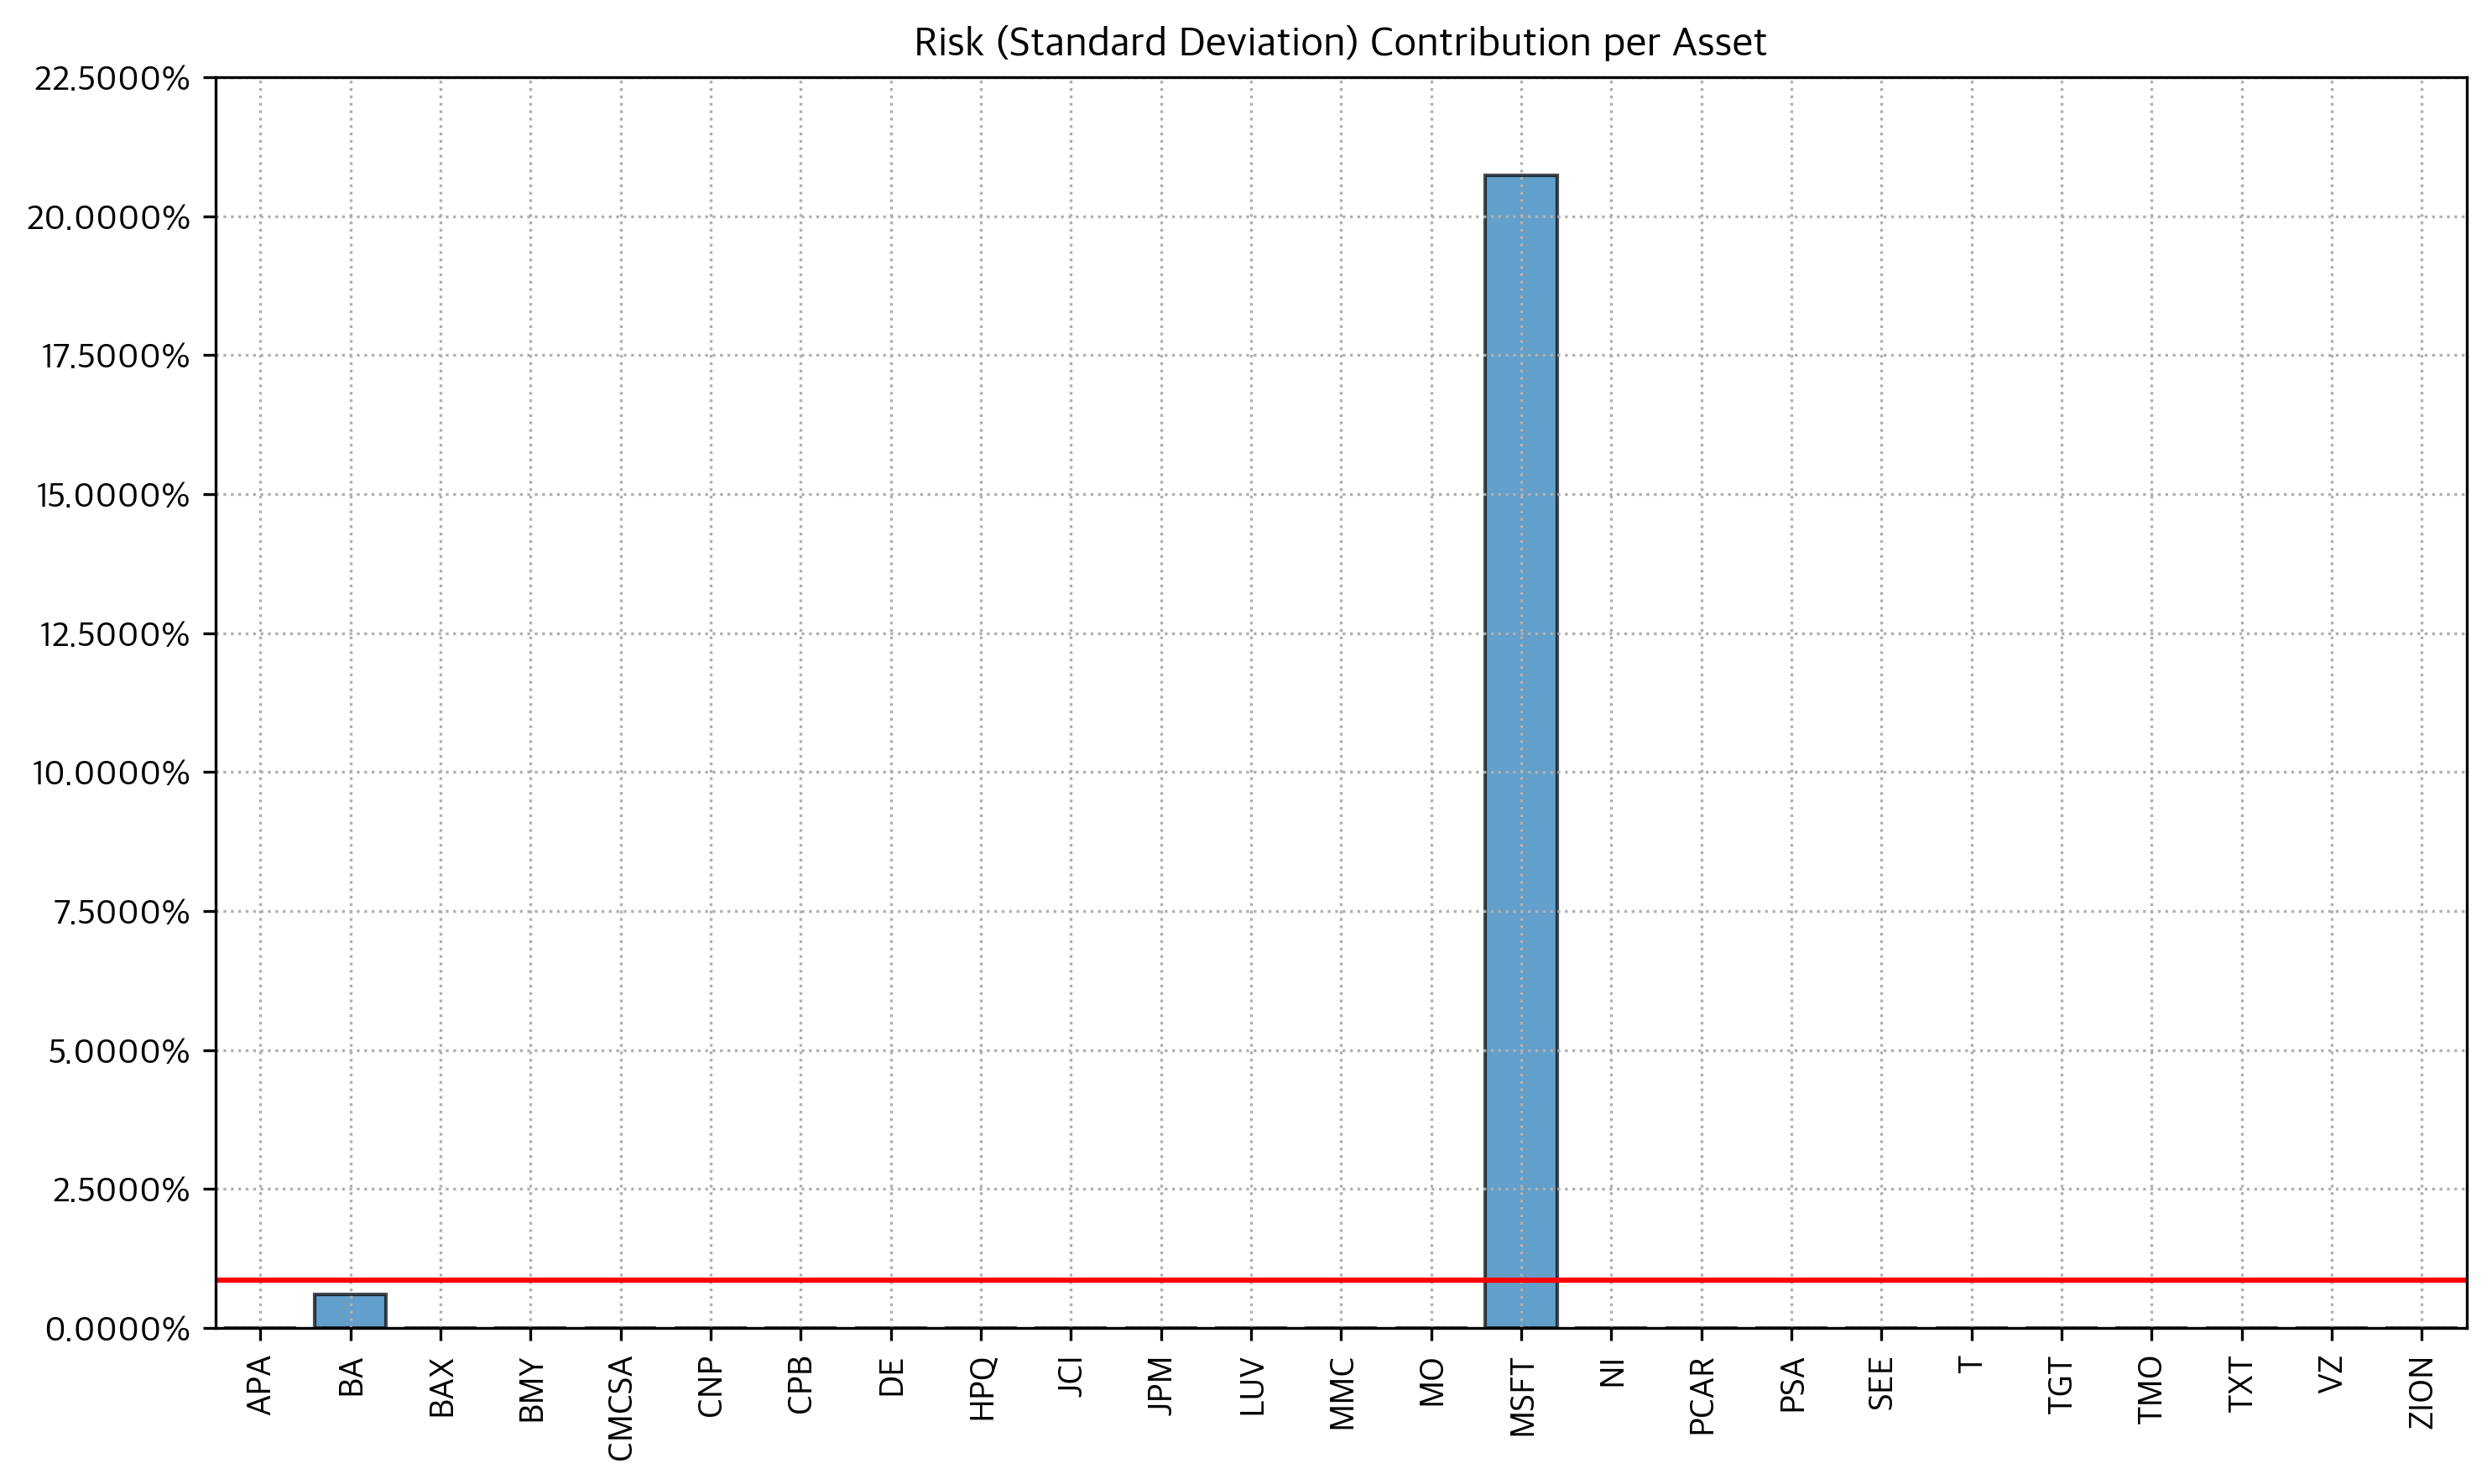

In [31]:
# Plotting the risk composition of the portfolio

ax = rp.plot_risk_con(w_wc_3, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

## 6. Estimating Worst Case Mean Variance Portfolios with Elliptical Uncertainty Sets based on Normallity Assumptions.

### 6.1 Calculating the worst case mean variance portfolio.

In [32]:
# Select method and estimate worst case input parameters:

box = 'n' # Method to estimate box uncertainty sets parameters
ellip = 'n' # Method to estimate elliptical uncertainty sets parameters
q = 0.05 # Confidence level for bootstrapping and k ellipsoidal uncertainty sets constraints
n_sim = 3000 # Number of scenarios for bootstrapping
window = 3 # Size of each block for block bootstrapping
dmu = 0.1 # delta to increase or decrease the mean vector
dcov = 0.1 # delta to increase or decrease the covariance matrix
seed = 0

port.wc_stats(box=box, ellip=ellip, q=q, n_sim=n_sim, window=window, dmu=dmu, dcov=dcov, seed=seed)

# Estimate worst case optimal portfolio using selected uncertainty sets:

Umu = 'ellip' # Type of uncertainty set for mean vector
Ucov = 'ellip' # Type of uncertainty set for covariance matrix

w_wc_4 = port.wc_optimization(obj=obj, rf=rf, l=l, Umu=Umu, Ucov=Ucov)

display(w_wc_4.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,5.0037%,0.0003%,0.0000%,0.0001%,0.0000%,0.0000%,0.0002%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0005%


이 코드는 박스(Box)와 타원(Elliptical) 불확실성 집합을 사용하여 최악의 시나리오를 고려한 포트폴리오 최적화를 수행하는 과정입니다. 이 코드는 `n` 방법을 사용하여 불확실성 집합의 파라미터를 추정합니다. 이 파라미터는 평균 벡터와 공분산 행렬을 기반으로 설정됩니다. 각 단계별로 코드를 설명하겠습니다.

### 코드 설명

1. **불확실성 집합 파라미터 설정**
   ```python
   box = 'n'  # Method to estimate box uncertainty sets parameters
   ellip = 'n'  # Method to estimate elliptical uncertainty sets parameters
   q = 0.05  # Confidence level for bootstrapping and k ellipsoidal uncertainty sets constraints
   n_sim = 3000  # Number of scenarios for bootstrapping
   window = 3  # Size of each block for block bootstrapping
   dmu = 0.1  # Delta to increase or decrease the mean vector
   dcov = 0.1  # Delta to increase or decrease the covariance matrix
   seed = 0  # Random seed for reproducibility
   ```

   - `box = 'n'`: 박스 불확실성 집합의 파라미터를 `n` 방법으로 추정합니다.
   - `ellip = 'n'`: 타원 불확실성 집합의 파라미터를 `n` 방법으로 추정합니다.
   - `q = 0.05`: 부트스트래핑과 타원 불확실성 집합 제약 조건을 위한 신뢰 수준.
   - `n_sim = 3000`: 부트스트래핑을 위한 시나리오 수.
   - `window = 3`: 블록 부트스트래핑을 위한 각 블록의 크기.
   - `dmu = 0.1`: 평균 벡터를 절대값으로 10% 증가 또는 감소시킴.
   - `dcov = 0.1`: 공분산 행렬을 절대값으로 10% 증가 또는 감소시킴.
   - `seed = 0`: 재현성을 위한 랜덤 시드 값.

2. **불확실성 집합 기반 통계량 계산**
   ```python
   port.wc_stats(box=box, ellip=ellip, q=q, n_sim=n_sim, window=window, dmu=dmu, dcov=dcov, seed=seed)
   ```

   - `wc_stats` 함수는 설정된 불확실성 집합 파라미터와 부트스트래핑 방법을 사용하여 최악의 경우에 대한 통계량을 계산합니다.
   - 이 함수는 불확실성 집합의 상한과 하한을 설정하고, 평균 벡터와 공분산 행렬의 변동 범위를 추정합니다.

3. **최악의 경우 최적화 수행**
   ```python
   Umu = 'ellip'  # Type of uncertainty set for mean vector
   Ucov = 'ellip'  # Type of uncertainty set for covariance matrix

   w_wc_4 = port.wc_optimization(obj=obj, rf=rf, l=l, Umu=Umu, Ucov=Ucov)
   ```

   - `Umu = 'ellip'`: 평균 벡터에 대한 불확실성 집합의 유형을 'ellip'로 설정합니다.
   - `Ucov = 'ellip'`: 공분산 행렬에 대한 불확실성 집합의 유형을 'ellip'로 설정합니다.
   - `wc_optimization` 함수는 설정된 불확실성 집합을 기반으로 최악의 경우에 대한 최적의 포트폴리오를 계산합니다.
   - `obj`: 최적화 목표 함수 (예: 'Sharpe', 'MinRisk', 'MaxRet', 'Utility' 등).
   - `rf`: 무위험 이자율.
   - `l`: 위험 회피 계수 (obj가 'Utility'일 때만 유용).

4. **최적 포트폴리오 가중치 출력**
   ```python
   display(w_wc_4.T)
   ```

   - `w_wc_4`: 최악의 경우 최적화를 통해 계산된 포트폴리오의 자산 가중치 벡터입니다.
   - `display(w_wc_4.T)`: 계산된 자산 가중치를 출력합니다.

### 전체 코드 요약

```python
import riskfolio as rp

# 불확실성 집합 파라미터 설정
box = 'n'
ellip = 'n'
q = 0.05
n_sim = 3000
window = 3
dmu = 0.1
dcov = 0.1
seed = 0

# 불확실성 집합 기반 통계량 계산
port.wc_stats(box=box, ellip=ellip, q=q, n_sim=n_sim, window=window, dmu=dmu, dcov=dcov, seed=seed)

# 최악의 경우 최적화 수행
Umu = 'ellip'
Ucov = 'ellip'

w_wc_4 = port.wc_optimization(obj=obj, rf=rf, l=l, Umu=Umu, Ucov=Ucov)

# 최적 포트폴리오 가중치 출력
display(w_wc_4.T)
```

### 요약

- **불확실성 집합 파라미터 설정**: `n` 방법을 사용하여 박스와 타원 불확실성 집합의 파라미터를 추정하고, 기타 파라미터를 설정합니다.
- **불확실성 집합 기반 통계량 계산**: 설정된 파라미터를 사용하여 불확실성 집합의 상한과 하한을 추정하고, 최악의 경우에 대한 통계량을 계산합니다.
- **최악의 경우 최적화 수행**: 추정된 불확실성 집합을 사용하여 최악의 경우에 최적의 포트폴리오를 계산합니다.
- **최적 포트폴리오 가중치 출력**: 계산된 최적의 포트폴리오 가중치를 출력합니다.

이를 통해 불확실성 집합을 고려한 포트폴리오 최적화를 수행하여, 다양한 리스크 시나리오에서 안정적인 포트폴리오를 구성할 수 있습니다.